In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import colormaps

%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 6, 6
plt.rc("font", size=18)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Data exploration
## Table Of Content:
* [**"generic" sklearn usage**](#sklearn-generic)
* [**Data prepartion for ML**](#first-bullet)
    * [First look at the data](#FL-bullet)
    * [Value transformation and variance stabilization](#TR-bullet)
    * [Missing Values](#MV-bullet)
    * [OneHot Encoding](#OH-bullet)

* [**Dimensionality reduction/Embedding**](#fourth-bullet)
    * [Principal component analysis](#PCA-bullet)
    * [PCA for immunogenicity dataset](#PCAi-bullet)
    * [t-SNE](#tsne-bullet)     
       
* [**Appendix**](#appendix-bullet)
    * [Whitening](#whiten-bullet)
    * [UMAP](#umap-bullet)
    * [Independant component analysis](#ICA-bullet)
    * [PCA for breast cancer data](#bc-bullet)
    * [PCA for Iris data](#iris-bullet)
    * [Looking at sklearn code](#code-bullet)
    

# "generic" sklearn usage <a id='sklearn-generic'></a>

The main library we will be using for machine learning is scikit-learn.

It should go without saying that if you have any questions regarding its usage and capabilities, your first stop should be their [website](https://scikit-learn.org/stable/),
especially since it provides plenty of [examples](https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html#sphx-glr-auto-examples-ensemble-plot-voting-decision-regions-py), [guides](https://scikit-learn.org/stable/user_guide.html), and [tutorials](https://scikit-learn.org/stable/tutorial/index.html#tutorial-menu).

Nevertheless, we introduce here the most common behavior of sklearn object.

Indeed, sklearn implement machine learning algorithms (random forest, clustering algorithm,...), as well as all kinds of preprocessers (scalin, missing value imputation,...) with a fairly consistent interface.

Most methods must first be instanciated as an object from a specific class:

```python
## import the class, here RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

## instanciate the class object:
my_clf = RandomForestClassifier()
```

As it stands, the object is just a "naive" version of the algorithm.

The next step is then to feed the object data, so it can learn from it. This is done with the `.fit` method:

```python
my_clf.fit( X , y )
```
> In this context, `X` is the data and `y` is the objective to attain. When the object is not an ML algorithm but a preprocessor, you only give the `X`

Now that the object has been trained with your data, you can use it. For instance, to:
* `.transform` your data (typically in the case of a preprocessor)
* `.predict` some output from data (typically in the case of an ML algorithm, like a classifier)

```python
y_predicted = clf.predict(X)  # predict classes of the training data

## OR 

X_scaled = myScaler.transform(X)  # apply a transformation to the data
```

Last but not least, it is common in example code to "fit and transform" a preprocesser in the same line using `.fit_transform`

```python
X_scaled = myNaiveScaler.fit_transform(X)  # equivalent to myNaiveScaler.fit(X).transform(X)
```

That's the basics. You will be able to experiment at length with this and go well beyond it.

<br>

# Data prepartion for ML <a class="anchor" id="first-bullet"></a>

### First look at the data <a class="anchor" id="FL-bullet"></a>

In this intoduction we are using a yeast Phospho proteomics dataset [Plank et al. MCP, 2020](https://doi.org/10.1074/mcp.RA120.001955). 
The study performed a LC-MS/MS experiment and label-free quantitation to study the effect of 3 AGC-kinases (Sch9, Pka1, Ypk1) inhibition on the phosphoproteome. Sch9, Pka1, Ypk1 were mutated in order to allow the 1NMPP1 molecule to bind to the mutant and inhibit its active site.

 * 5 yeast strains were used: WT, and Sch9, Pka1, Sch9&Pka1, Ypk1 mutant strains. 
 * Each strain was exposed to either DMSO (control) or 1NMPP1 (treatment).
 * All measurements were performed in 3 technical replicates.
 
 So in total there are $5*2*3 = 30$ samples

In [13]:
import pandas as pd
X_ph = pd.read_csv("../data/plank2020_phosphoprot_log10.csv", index_col=0)
X_ph

WT_DMSO  WT_DMSO.1  WT_DMSO.2  WT_1NMPP1  \
Peptide sequence                                                              
ADDEEDLS(Phospho)DENIQPELR        8.111105   8.139281   8.101774   8.038697   
NVVDENLINDMDS(Phospho)EDAHK       0.000000   0.000000   0.000000   0.000000   
SNS(Phospho)IDYAK                 6.979009   6.954673   6.949864   6.984677   
AST(Phospho)PPVK                  0.000000   0.000000   0.000000   5.807965   
KEPVKT(Phospho)PS(Phospho)PAPAAK  7.254044   7.258416   7.217928   7.212294   
...                                    ...        ...        ...        ...   
NNS(Phospho)DDETEHTSAIK           6.820271   6.814394   6.830445   6.792115   
RNNS(Phospho)DDETEHTSAIK          7.094685   7.030965   6.582416   7.069241   
RKS(Phospho)EGECCDLNK             7.751795   7.641177   7.556734   7.659362   
NHTWS(Phospho)EFER                9.020039   8.898703   8.939573   8.918927   
NHTWS(Phospho)EFERIEAEK           7.193477   6.554763   6.907142   7.135448   

                                  WT_1NMPP1.1  WT_1NMPP1.2  Sch9_DMSO  \
Peptide sequence                                                        
ADDEEDLS(Phospho)DENIQPELR           8.081764     8.058197   8.071512   
NVVDENLINDMDS(Phospho)EDAHK          0.000000     0.000000   0.000000   
SNS(Phospho)IDYAK                    6.940531     6.969075   7.067305   
AST(Phospho)PPVK                     5.745374     5.847605   0.000000   
KEPVKT(Phospho)PS(Phospho)PAPAAK     7.219502     6.163339   0.000000   
...                                       ...          ...        ...   
NNS(Phospho)DDETEHTSAIK              6.772370     6.752684   6.783501   
RNNS(Phospho)DDETEHTSAIK             6.706789     6.698541   6.716111   
RKS(Phospho)EGECCDLNK                7.601941     7.601952   7.282123   
NHTWS(Phospho)EFER                   8.891321     8.943726   8.860410   
NHTWS(Phospho)EFERIEAEK              6.995702     7.156413   7.255607   

                                  Sch9_DMSO.1  Sch9_DMSO.2  Sch9_1NMPP1  ...  \
Peptide sequence                                                         ...   
ADDEEDLS(Phospho)DENIQPELR           8.165305     8.080783     8.132232  ...   
NVVDENLINDMDS(Phospho)EDAHK          0.000000     0.000000     6.888168  ...   
SNS(Phospho)IDYAK                    7.071589     6.999701     7.135595  ...   
AST(Phospho)PPVK                     6.212480     6.184184     6.172707  ...   
KEPVKT(Phospho)PS(Phospho)PAPAAK     0.000000     0.000000     7.902286  ...   
...                                       ...          ...          ...  ...   
NNS(Phospho)DDETEHTSAIK              6.845834     6.796550     6.724822  ...   
RNNS(Phospho)DDETEHTSAIK             6.744561     6.666889     5.553506  ...   
RKS(Phospho)EGECCDLNK                7.401181     7.183214     7.095320  ...   
NHTWS(Phospho)EFER                   8.553804     8.871640     8.819530  ...   
NHTWS(Phospho)EFERIEAEK              0.000000     7.180694     6.672452  ...   

                                  Sch9_Pka1_DMSO.2  Sch9_Pka1_1NMPP1  \
Peptide sequence                                                       
ADDEEDLS(Phospho)DENIQPELR                8.111381          8.061021   
NVVDENLINDMDS(Phospho)EDAHK               0.000000          0.000000   
SNS(Phospho)IDYAK                         6.910873          7.153575   
AST(Phospho)PPVK                          0.000000          0.000000   
KEPVKT(Phospho)PS(Phospho)PAPAAK          0.000000          8.006840   
...                                            ...               ...   
NNS(Phospho)DDETEHTSAIK                   6.683810          6.744256   
RNNS(Phospho)DDETEHTSAIK                  0.000000          6.693991   
RKS(Phospho)EGECCDLNK                     7.339628          7.007412   
NHTWS(Phospho)EFER                        8.861836          8.951548   
NHTWS(Phospho)EFERIEAEK                   6.799468          7.284443   

                                  Sch9_Pka1_1NMPP1.1  Sch9_Pka1_1NMPP1.2  \
Pep

We can look at the reproducibility of the replicates using seaborn `pairplot`.

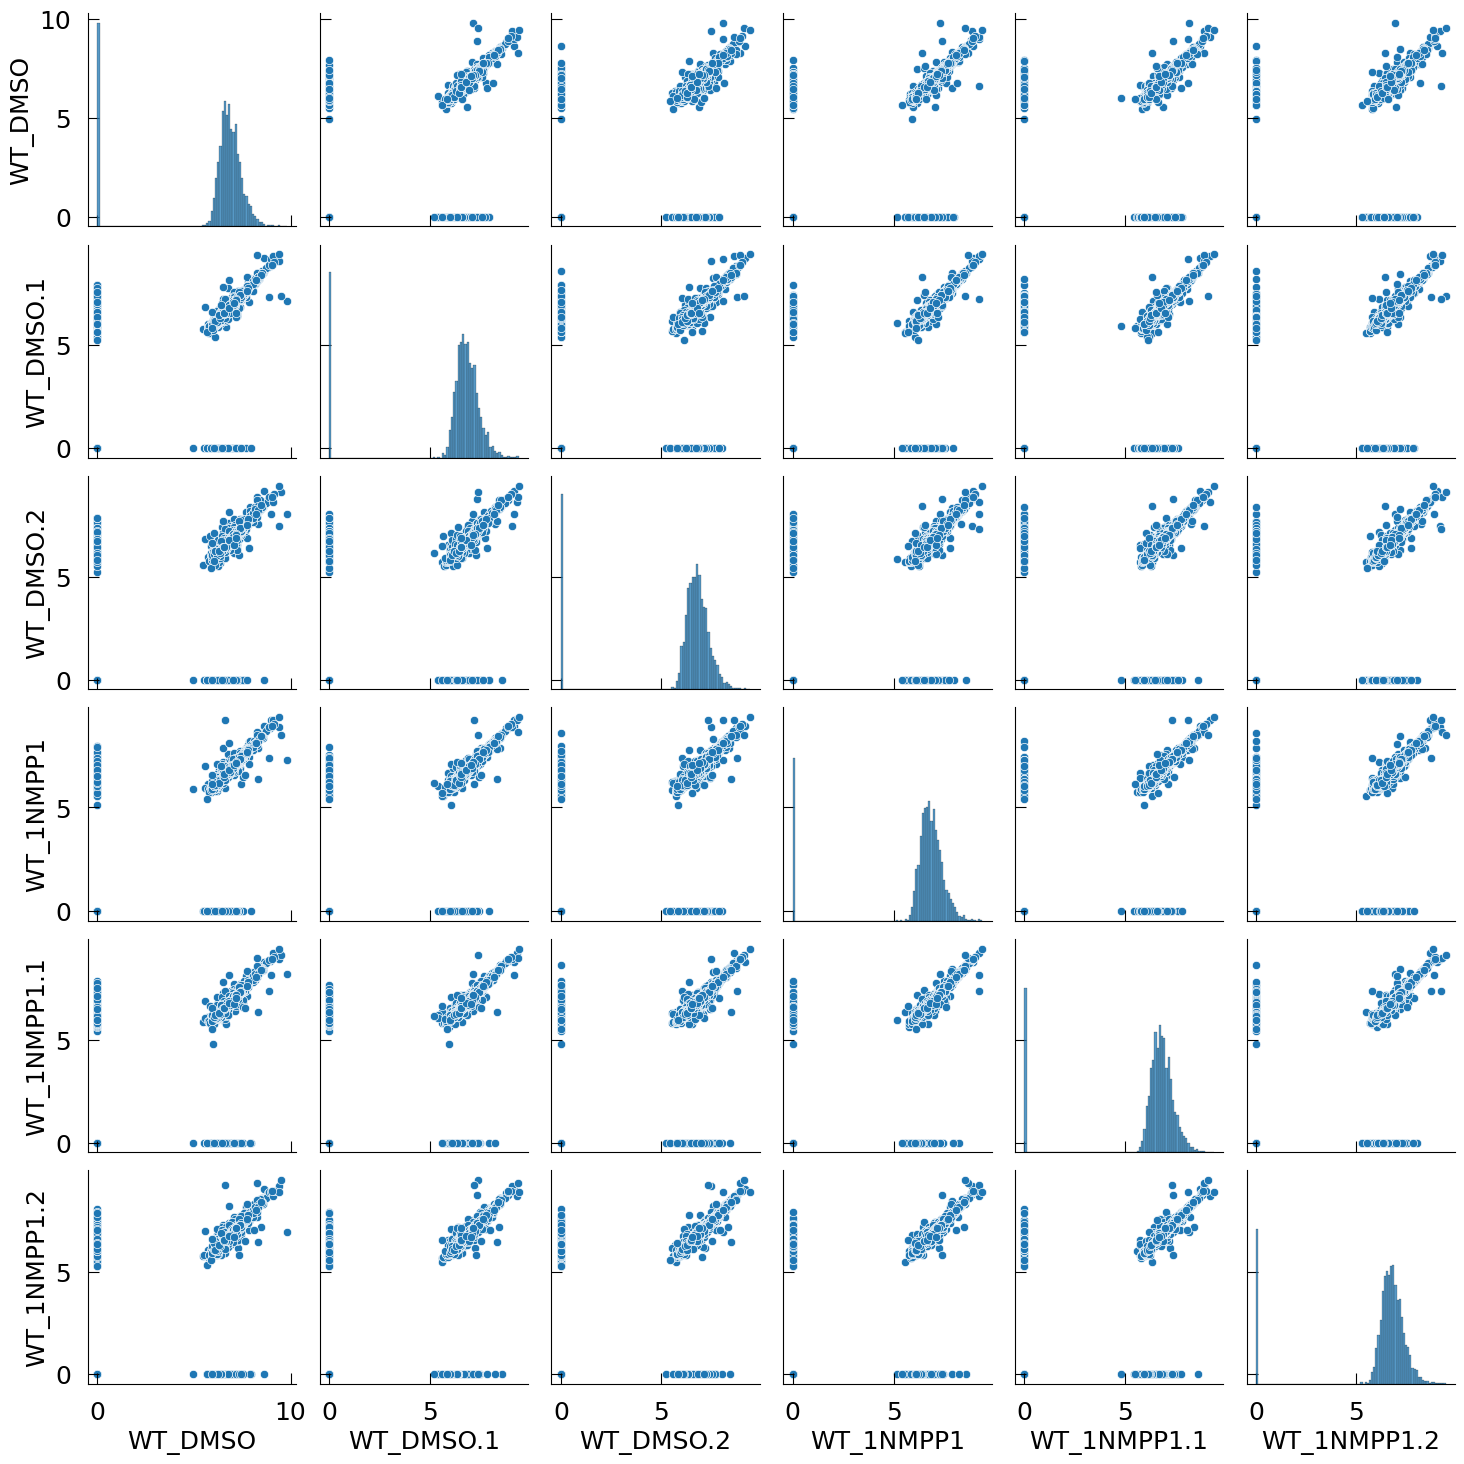

In [14]:
sns.pairplot(X_ph.iloc[:,0:6])

The data, corrresponding to phosphopeptide intensities, has been transformed with log10(1+x).

Without this transformation we would see a much wider spread of variance for high intensities (heteroskedascticity).

<Axes: xlabel='WT_DMSO', ylabel='WT_DMSO.1'>

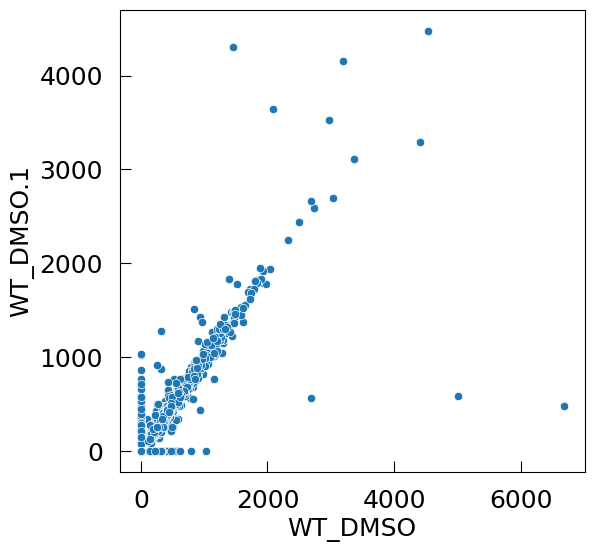

In [15]:
## reversing the log10(x+1) transform
sns.scatterplot( x = np.exp( X_ph["WT_DMSO"]-1 ),
                 y = np.exp( X_ph["WT_DMSO.1"] -1 ) )

With either the original or the log-transformed data, we see a clear set of points at 0.

For this kind of data (quantitative proteomics, and other -omics), this corresponds to **missing values**.

### Missing Values <a class="anchor" id="MV-bullet"></a>

In [16]:
## missing values are the 0s
(X_ph == 0).sum()

WT_DMSO               385
WT_DMSO.1             353
WT_DMSO.2             370
WT_1NMPP1             309
WT_1NMPP1.1           312
WT_1NMPP1.2           293
Sch9_DMSO             400
Sch9_DMSO.1           350
Sch9_DMSO.2           338
Sch9_1NMPP1           295
Sch9_1NMPP1.1         376
Sch9_1NMPP1.2         379
Pka1_DMSO             380
Pka1_DMSO.1           387
Pka1_DMSO.2           421
Pka1_1NMPP1           388
Pka1_1NMPP1.1         408
Pka1_1NMPP1.2         388
Sch9_Pka1_DMSO        420
Sch9_Pka1_DMSO.1      390
Sch9_Pka1_DMSO.2      334
Sch9_Pka1_1NMPP1      394
Sch9_Pka1_1NMPP1.1    396
Sch9_Pka1_1NMPP1.2    395
Ypk1_DMSO             369
Ypk1_DMSO.1           364
Ypk1_DMSO.2           366
Ypk1_1NMPP1           349
Ypk1_1NMPP1.1         405
Ypk1_1NMPP1.2         457
dtype: int64

For around 2900 phosphopeptides, it is a non-negligible amount of missing data.

Missing values are common in many datasets.

In proteomics data they can be caused, among other, by :

 * the absence of the peptide in the original sample
 * a lack of sensitivity of the mass spectrometers 
 * inaccuracies in the computational data processing
 



In order to get a better look at the entire dataset, we plot the data as a heatmap:

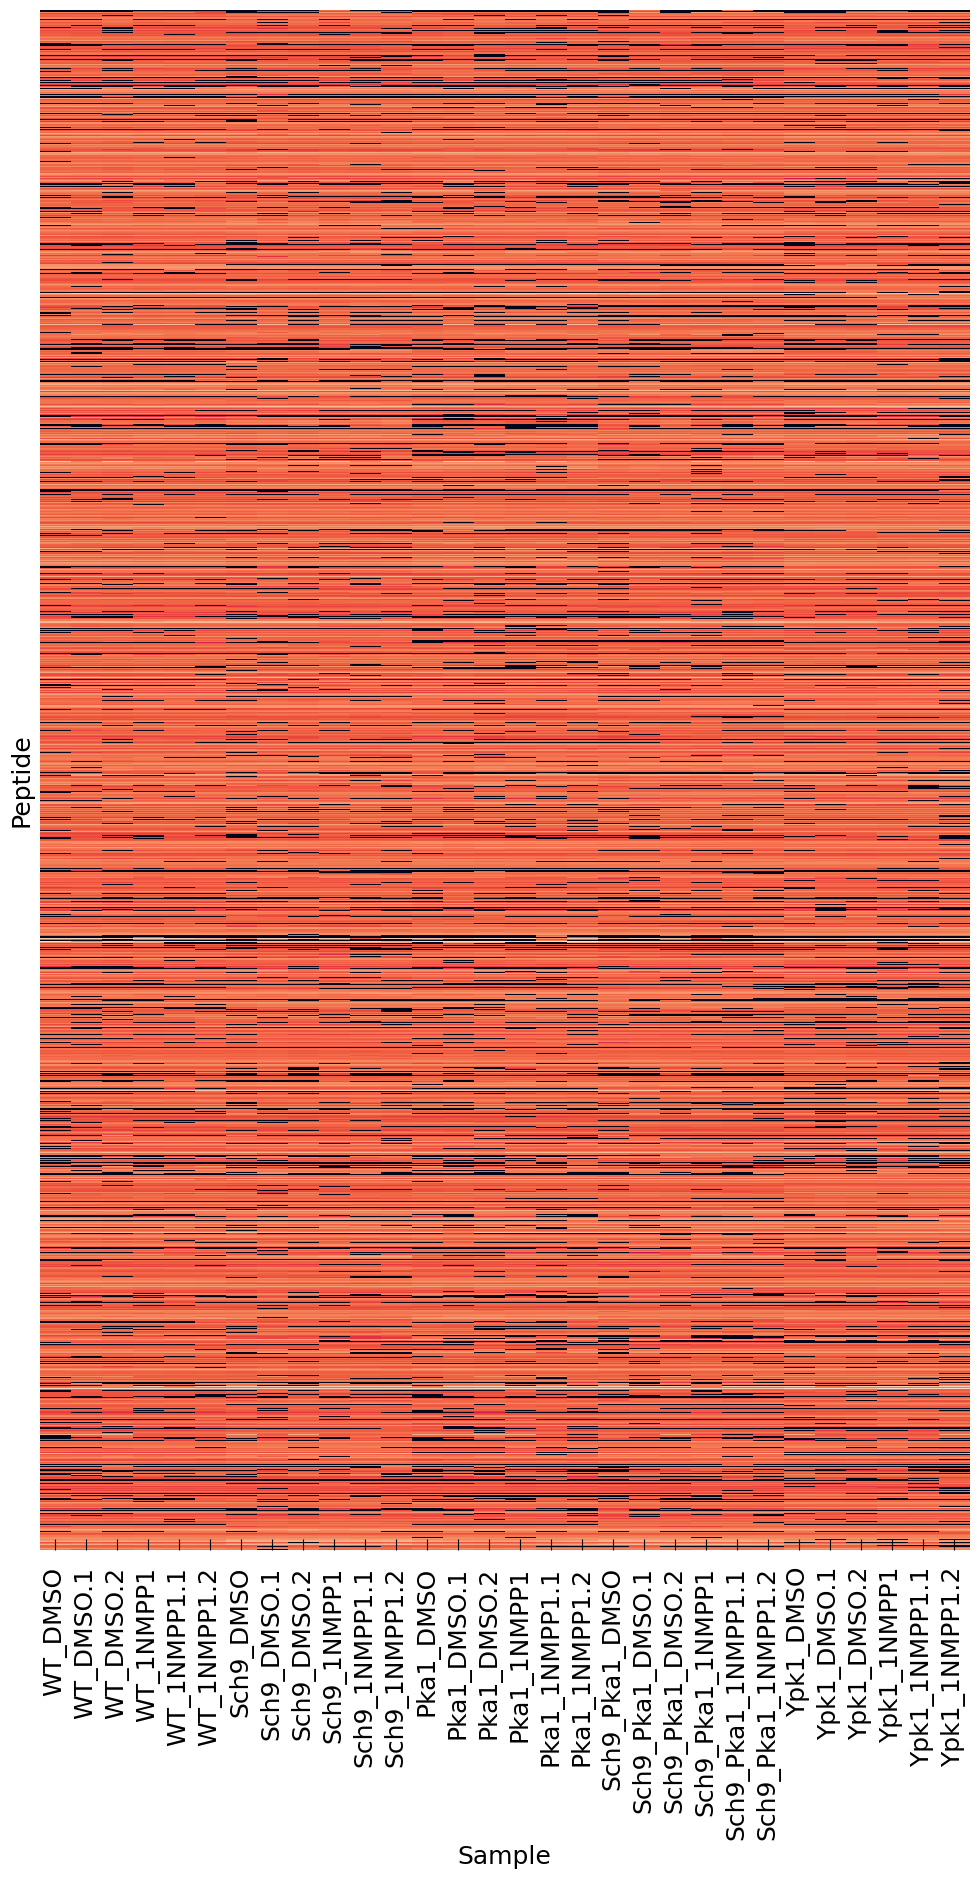

In [17]:
plt.figure(figsize=(12,20))
#X_ph.set_index(df_ph['Peptide sequence'], inplace=True)
ax = sns.heatmap(X_ph, cbar=False,yticklabels=False)
plt.xlabel("Sample")
plt.ylabel("Peptide")
plt.show()

This shows that the missing or zero values (dark lines) are ubiquitous. 

The missing values are not uniformly randomly distributed but more likely for low intensity peptides: the average peptide intensity decreases with increasing number of missing values per peptide. 

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

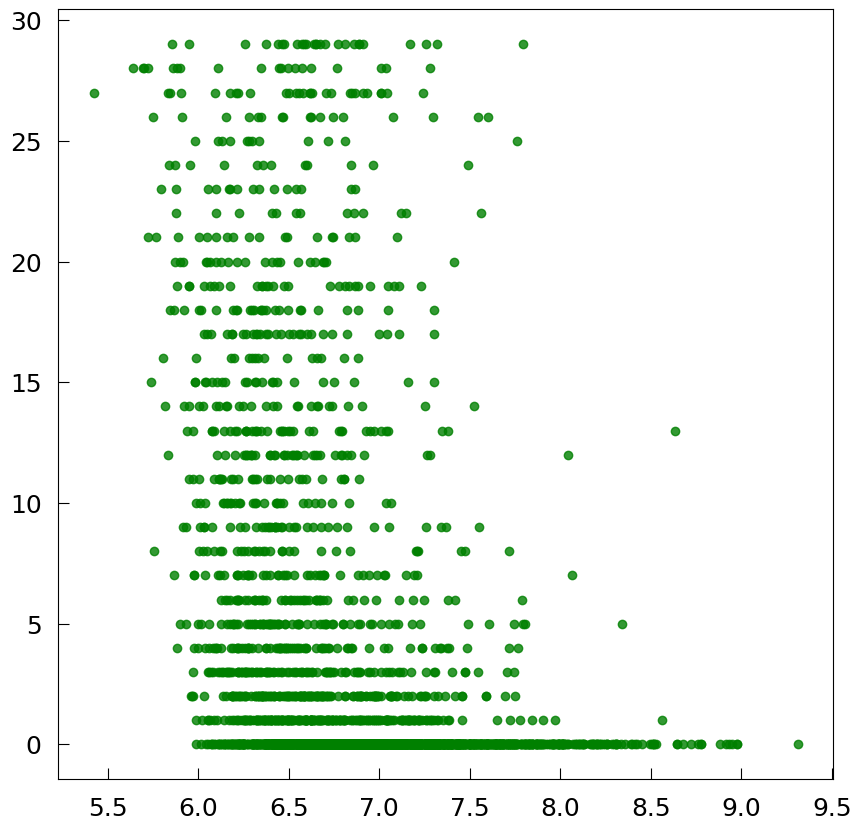

In [18]:
avg = X_ph[X_ph>0].mean(axis=1)
nr_missing = (X_ph==0).sum(axis=1)

plt.figure(figsize=(10,10))
sns.regplot(y=nr_missing, x=avg, lowess=True, color="g",line_kws={'color':"red"})
plt.xlabel('Peptide average positive log10(Intensity)')
plt.ylabel('Number missing values per peptide')
plt.show(block=False)

They are many ways to deal with missing values : 

 * removing all peptides with missing values
 * replacing them with a fixed mock value (eg, the mean, or median)
 * giving them the average of the value of their closest neighbours ([KNN imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html), [MissForest](https://academic.oup.com/bioinformatics/article/28/1/112/219101))
 * a mix of the different approaches
 * ...
 

Imputation could warrant its own course, but here, it suffice to remark that we are confronted to a **modelling choice** : how to do the imputation on our data?
 
 > Note: only a few statistical and ML methods can handle missing values so in most case we have to do something about them


---

We can try a few of the strategies:

**Removing all peptides with missing values**

In [21]:
X_ph_positive = X_ph[(X_ph>0).all(axis=1)]
n_removed = X_ph.shape[0] - X_ph_positive.shape[0]
print( f"removed {n_removed} peptides ({100*n_removed/X_ph.shape[0]:.1f}%)" )

removed 1260 peptides (42.6%)


**Impute all zero values with the mean** of all positive values for each peptide (row):

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=0, strategy='mean')

## the sklearn function generally operate at the column level, 
##  but we we to operate at the row level (ie, peptide-level)
## so we have to do some ugly transposition:

X_phT = X_ph.transpose() # switch rows and columns

tmp = imputer.fit_transform(X_phT) ## imputation

# transpose and transform to  dataframe
X_ph_meanI = pd.DataFrame( tmp.T, columns=X_ph.columns, index=X_ph.index) 

X_ph_meanI.head()

WT_DMSO  WT_DMSO.1  WT_DMSO.2  WT_1NMPP1  \
Peptide sequence                                                              
ADDEEDLS(Phospho)DENIQPELR        8.111105   8.139281   8.101774   8.038697   
NVVDENLINDMDS(Phospho)EDAHK       6.908059   6.908059   6.908059   6.908059   
SNS(Phospho)IDYAK                 6.979009   6.954673   6.949864   6.984677   
AST(Phospho)PPVK                  6.033875   6.033875   6.033875   5.807965   
KEPVKT(Phospho)PS(Phospho)PAPAAK  7.254044   7.258416   7.217928   7.212294   

                                  WT_1NMPP1.1  WT_1NMPP1.2  Sch9_DMSO  \
Peptide sequence                                                        
ADDEEDLS(Phospho)DENIQPELR           8.081764     8.058197   8.071512   
NVVDENLINDMDS(Phospho)EDAHK          6.908059     6.908059   6.908059   
SNS(Phospho)IDYAK                    6.940531     6.969075   7.067305   
AST(Phospho)PPVK                     5.745374     5.847605   6.033875   
KEPVKT(Phospho)PS(Phospho)PAPAAK     7.219502     6.163339   7.449571   

                                  Sch9_DMSO.1  Sch9_DMSO.2  Sch9_1NMPP1  ...  \
Peptide sequence                                                         ...   
ADDEEDLS(Phospho)DENIQPELR           8.165305     8.080783     8.132232  ...   
NVVDENLINDMDS(Phospho)EDAHK          6.908059     6.908059     6.888168  ...   
SNS(Phospho)IDYAK                    7.071589     6.999701     7.135595  ...   
AST(Phospho)PPVK                     6.212480     6.184184     6.172707  ...   
KEPVKT(Phospho)PS(Phospho)PAPAAK     7.449571     7.449571     7.902286  ...   

                                  Sch9_Pka1_DMSO.2  Sch9_Pka1_1NMPP1  \
Peptide sequence                                                       
ADDEEDLS(Phospho)DENIQPELR                8.111381          8.061021   
NVVDENLINDMDS(Phospho)EDAHK               6.908059          6.908059   
SNS(Phospho)IDYAK                         6.910873          7.153575   
AST(Phospho)PPVK                          6.033875          6.033875   
KEPVKT(Phospho)PS(Phospho)PAPAAK          7.449571          8.006840   

                                  Sch9_Pka1_1NMPP1.1  Sch9_Pka1_1NMPP1.2  \
Peptide sequence                                                           
ADDEEDLS(Phospho)DENIQPELR                  8.110272            8.095640   
NVVDENLINDMDS(Phospho)EDAHK                 6.947316            6.908059   
SNS(Phospho)IDYAK                           7.181344            7.049465   
AST(Phospho)PPVK                            6.033875            6.033875   
KEPVKT(Phospho)PS(Phospho)PAPAAK            7.912034            7.923167   

                                  Ypk1_DMSO  Ypk1_DMSO.1  Ypk1_DMSO.2  \
Peptide sequence                                                        
ADDEEDLS(Phospho)DENIQPELR         8.011904     7.977381     7.995326   
NVVDENLINDMDS(Phospho)EDAHK        6.908059     6.908059     6.908059   
SNS(Phospho)IDYAK                  6.632757     6.648691     6.715855   
AST(Phospho)PPVK                   6.033875     6.033875     5.752769   
KEPVKT(Phospho)PS(Phospho)PAPAAK   7.449571     7.449571     7.679796   

                                  Ypk1_1NMPP1  Ypk1_1NMPP1.1  Ypk1_1NMPP1.2  
Peptide sequence                                                             
ADDEEDLS(Phospho)DENIQPELR           7.989487       8.002461       8.009906  
NVVDENLINDMDS(Phospho)EDAHK          6.908059       6.908059       6.908059  
SNS(Phospho)IDYAK                    6.623836       6.632217       6.782414  
AST(Phospho)PPVK                     6.086799       6.033875       6.033875  
KEPVKT(Phospho)PS(Phospho)PAPAAK     7.719625       7.713210       7.778927  

[5 rows x 30 columns]

**KNN imputation**: get the value of your K closest neigbours:

In [24]:
from sklearn.impute import KNNImputer

## we will look for the closest 5 peptides
imputer = KNNImputer( missing_values=0, n_neighbors=5 ) 


tmp = imputer.fit_transform( X_ph ) # no need for transposition here

## transforming back to a dataframe so we have columns and row names
X_ph_knnI = pd.DataFrame( tmp, columns=X_ph.columns, index=X_ph.index) 



So we have these different strategies, but we have to choose **which one is the best for us?**

A typical ML approach is to have a **performance-oriented decision strategy**.

This means that we abstract ourselves away from theoretical concerns to put forward **criteria of good or bad performance**.

Then we compute **metrics** evaluating criteria for each possible choice and then compare them.


Here, our fear is that the imputation removes interesting information or introduces noise.

We also have some luck here (or rather, good experimental design): we have the technical replicates for each condition. 
Assuming that technical replicate should be similar to one another, we will say that a method is bad if it lead it less correlation between the technical replicates, and it is **good if it increases correlation between technical replicates**

---

We can vizualize this for the strategy where we remove the missing data entirely:

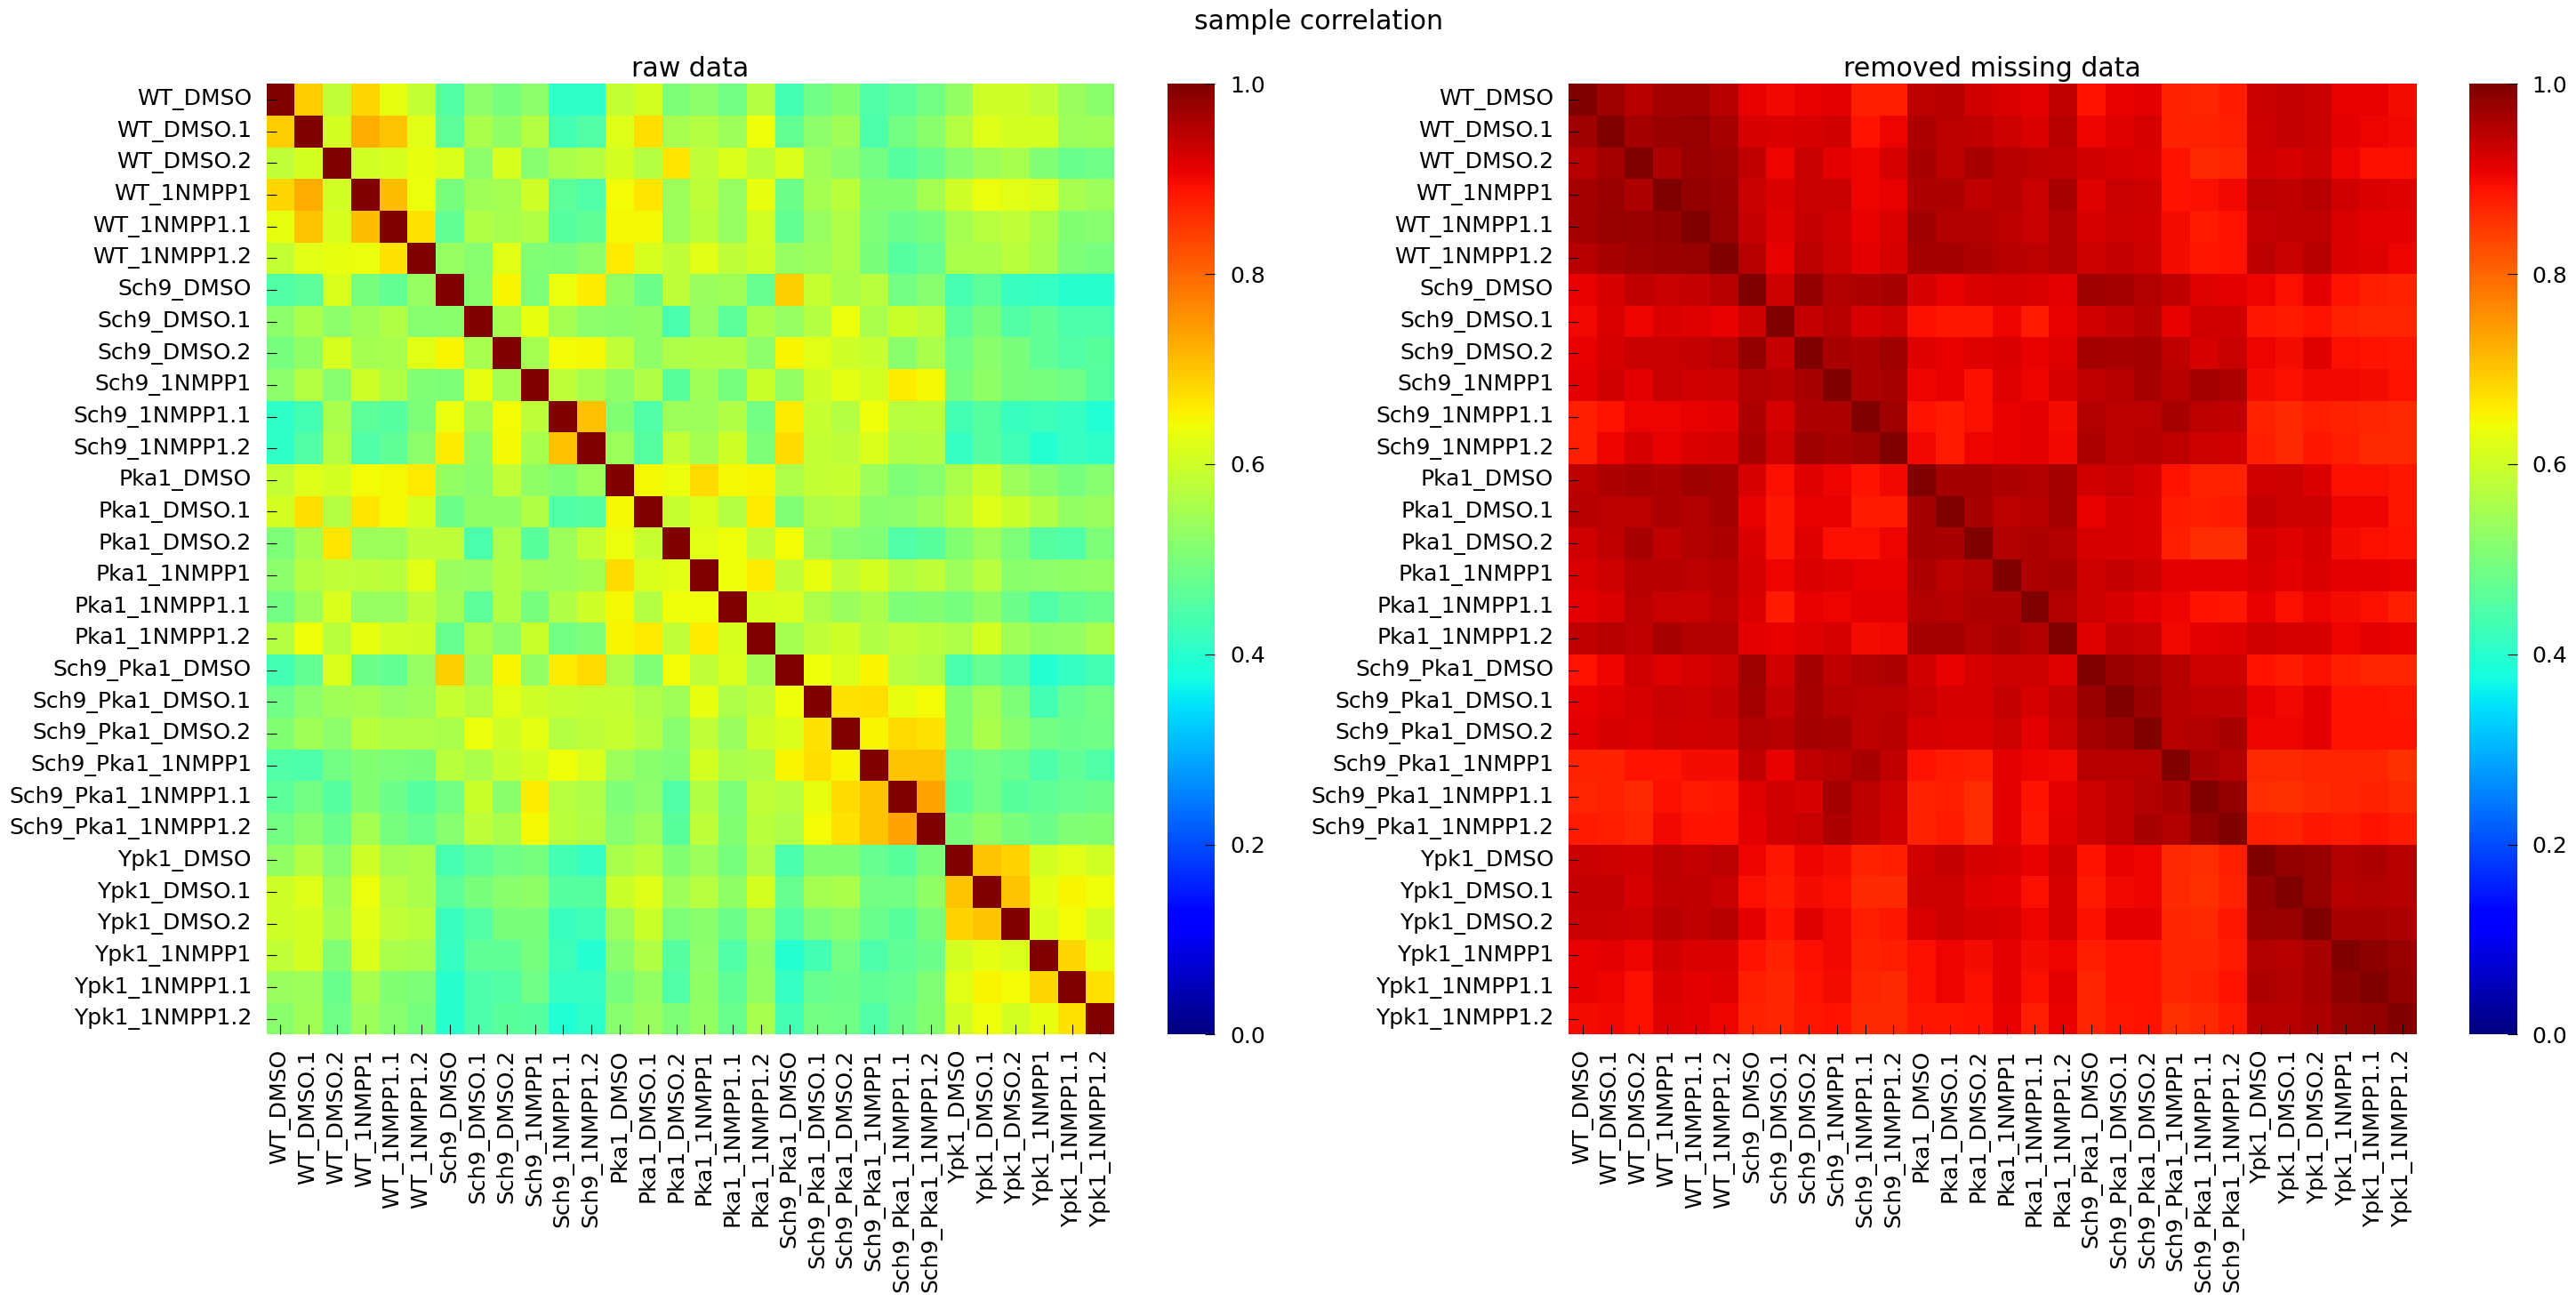

In [25]:
fig,ax = plt.subplots( 1,2,figsize=(30,15))

sns.heatmap(X_ph.corr(),ax=ax[0], cmap='jet' , vmin = 0 , vmax = 1)
ax[0].set_title("raw data")

sns.heatmap(X_ph_positive.corr(), ax= ax[1], cmap='jet' , vmin = 0 , vmax = 1)
ax[1].set_title("removed missing data")

fig.suptitle('sample correlation')
plt.tight_layout()

Compute a single number is a bit more involved (and dataset specific):

In [26]:
def get_avg_replicate_corr(data):
    conditions = ['WT_DMSO','WT_1NMPP1','Sch9_DMSO','Sch9_1NMPP1',
                  'Pka1_DMSO','Pka1_1NMPP1','Sch9_Pka1_DMSO','Sch9_Pka1_1NMPP1',
                  'Ypk1_DMSO','Ypk1_1NMPP1']

    replicate_avg_cor = 0
    for c in conditions:
        corr_mat = data[ [c , c+'.1' , c+'.2'] ].corr()
        # remove the diagonal (3) and divide by nuber of remaning cells (6)
        replicate_avg_cor += (corr_mat.sum().sum()-3)/6
    
    return replicate_avg_cor/len(conditions)
    

    
print(f"Average replicate correlation - raw data : {get_avg_replicate_corr(X_ph):.3f}")
print(f"Average replicate correlation - removed missing values : {get_avg_replicate_corr(X_ph_positive):.3f}")

Average replicate correlation - raw data : 0.646
Average replicate correlation - removed missing values : 0.968


We can see that removing the missing values has had a positive effect here.

**Micro exercise** : compute the correlation between replicates for the two other imputation strategies we tried. Which one is the most appropriate ?

In [28]:
print(f"Average replicate correlation - Mean Imputation : {get_avg_replicate_corr(X_ph_meanI):.3f}")
print(f"Average replicate correlation - KNN Imputation : {get_avg_replicate_corr(X_ph_knnI):.3f}")

Average replicate correlation - Mean Imputation : 0.960
Average replicate correlation - KNN Imputation : 0.958


In [ ]:
# %load solutions/solution_01_ME1.py

> For more imputation techniques check : [Scikit-learn imputation](https://scikit-learn.org/stable/modules/impute.html). There is abundant literature and sophisticated methods on missing value imputation. Unfortunately we cannot cover this important subject in this course.

---

### One hot encoding of categorical data <a class="anchor" id="OH-bullet"></a>

Certain ML algorithms (linear models, SVMs, NNs) require numerical values. Ordered categorical features (e.g. size = small, medium, large) or features with just two values can just be enumerated (e.g. size = 1,2,3). However, unordered categorical features or factors (e.g. color = blue, gray, pink) need to be turned into orthogonal vectors of 0 and 1, where each index in the vector corresponds to a level of the factor (e.g. blue = (1,0,0), gray = (0,1,0) and pink = (0,0,1). This is the so-called OneHot encoding of categorical features.

For instance, let's consider the following toy dataset with 3 columns : 2 categorical and 1 ordinal.

In [29]:
df = pd.DataFrame({'A': ['a', 'b', 'a'], 
                   'B': ['b', 'a', 'c'],
                   'C': [1, 2, 3]})
df

A  B  C
0  a  b  1
1  b  a  2
2  a  c  3

In [30]:
# method 1 : pd.get_dummies( ... )
pd.get_dummies( df )

C    A_a    A_b    B_a    B_b    B_c
0  1   True  False  False   True  False
1  2  False   True   True  False  False
2  3   True  False  False  False   True

In [31]:
# method 2 : sklearn OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
cat = df[['A','B']] # here we only perform the encoding with columns A and B
ohe = pd.DataFrame(enc.fit_transform(cat).toarray())

ohe.head()

0    1    2    3    4
0  1.0  0.0  0.0  1.0  0.0
1  0.0  1.0  1.0  0.0  0.0
2  1.0  0.0  0.0  0.0  1.0


You can choose to use one or the other depending on your needs, habits, and/or the format of your original data.

Note that there are **as many columns created as factor values**. This can lead to somewhat redundant/perfectly correlated columns (e.g. columns `A_a` and `A_b` are the converse of the one another) which can be detrimental (for instance, linear regressions expect that the covariables are not colinear). 

You can use the `drop_first=True` option of `pd.get_dummies` get rid of these "extra" columns:

In [32]:
pd.get_dummies( df , drop_first=True )

C    A_b    B_b    B_c
0  1  False   True  False
1  2   True  False  False
2  3  False  False   True

 ---

For this section and the next, we are going to introduce another dataset: the [Extrovert vs. Introvert](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/) dataset from kaggle user Rakesh Kapilavayi.

According to the author, the dataset was collected through Google Forms as part of a college-level student research project focused on personality traits and behavioral tendencies among students. 

Participants responded to questions on fixed scales for consistency and simplicity in analysis.

The features are:

 - Time_spent_Alone: Hours spent alone daily (0–11).
 - Stage_fear: Presence of stage fright (Yes/No).
 - Social_event_attendance: Frequency of social events (0–10).
 - Going_outside: Frequency of going outside (0–7).
 - Drained_after_socializing: Feeling drained after socializing (Yes/No).
 - Friends_circle_size: Number of close friends (0–15).
 - Post_frequency: Social media post frequency (0–10).
 - Personality: self-defined label (Extrovert/Introvert).



In [116]:
dfie = pd.read_csv( '../data/personality_dataset.csv' )
dfie.head()

Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0             5.0   Extrovert

In [34]:
dfie.shape

(2900, 8)

as you can see there are 3 categorical columns. As they are binary a simple one hot encoding should do fine:

In [35]:
dfie_OH = pd.get_dummies( dfie , drop_first=True )
dfie_OH.head()

Time_spent_Alone  Social_event_attendance  Going_outside  \
0               4.0                      4.0            6.0   
1               9.0                      0.0            0.0   
2               9.0                      1.0            2.0   
3               0.0                      6.0            7.0   
4               3.0                      9.0            4.0   

   Friends_circle_size  Post_frequency  Stage_fear_Yes  \
0                 13.0             5.0           False   
1                  0.0             3.0            True   
2                  5.0             2.0            True   
3                 14.0             8.0           False   
4                  8.0             5.0           False   

   Drained_after_socializing_Yes  Personality_Introvert  
0                          False                  False  
1                           True                   True  
2                           True                   True  
3                          False                  False  
4                          False                  False

<font size="6"> Enough with data processing let's start some real science </font>

## Dimensionality reduction <a class="anchor" id="fourth-bullet"></a>

Dimensionality reduction serves two puposes

 * **Visualization**: reducing the number of dimensions to 2 or 3 allows displaying the whole dataset for visual inspection
 * **Data compression**: some features may be little informative and projecting feature vectors to the principal data manifold allows discarding the uninformative part of the feature space


### Principal Component Analysis (PCA) <a class="anchor" id="PCA-bullet"></a>

As described in the lecture notes, PCA finds the direction in feature space with the largest variance (first principal component), meaning the direction where the data points are most spread out. Then it repeats the same algorithm to find the direction orthogonal to the first principal component (second principal component) with the largest (remaining) variance. The second principal component can only give information about the variance not explained by the first component. Mathematically this boils down to the eigenvalue decomposition or diagonalization of the covariance matrix, where the eigenvalue is the variance of the data along its eigenvector (principal component).

In PCA are looking for the matrix of eigenvalues $\pmb{D}$ and orthogonal basis vectors (eigenvectors) $\pmb{W}$, that satisfies the following relation:

$\pmb{X}^T\pmb{X}=\pmb{W}\pmb{D}\pmb{W}^T$

$\pmb{X}$ must be centered around the mean value of each feature vector (each column in the dataframe has zero empirical mean), so that $\pmb{Q}=\pmb{X}^T\pmb{X}$ is the covariance matrix of your multidimensional data (zero centering is done by the PCA algorithm, so no need to do it yourself).

> Note: algorithms that perfom PCA generally use Singular Value Decomposition (SVD). 

![PCA illustration](../images/PCA.png)

The output of such a process is a set of eigenvectors or PCs (which are a linear combination of your former features) and the variance corresponding to each eigenvector (eigenvalues). The eigenvalues are in decreasiung order to give us their decreasing signficance to explain the overall variance. The Scikit-learn [PCA class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) has, as other scikit classes, two main methods: fit() and transform(). For a data matrix $\pmb{X}$ of size NxM (N data rows, M feature colums) the fit($\pmb{X}$) calculates $\pmb{W}$ (with the M PCs as columns) of $\pmb{X}$ and the transform($\pmb{X}$) method provides the coordinates of the N data vectors in the eigenvector or principal component space by calculating $\pmb{X'}=\pmb{X}\pmb{W}$ (in case of 'whiten'=False).

PCA analysis has a clear mathematical framework and is fast to calculate (compared to t-SNE, for example). It can be easily applied to distributed data and is therefore also attractive for very large datasets. It also serves as a preprocessing step to de-correlate or 'whiten' a data matrix (see Appendix).

### PCA on the phospho peptide dataset

In [36]:
from sklearn.decomposition import PCA
pca = PCA() #create an empty PCA object

pca.fit(X_ph_positive) # calculates variances (eigenvalues)) and principal components (eigenvectors)

x_pca = pca.transform(X_ph_positive) # calculates coordinates of row vectors in X in PC space

## pca.explained_variance_ratio_ contains the fraction of the variance explained by each PCA axis (don't forget the _ at the end) 
pca.explained_variance_ratio_

array([9.23422244e-01, 2.49053707e-02, 1.43663931e-02, 6.69612213e-03,
       5.88912825e-03, 3.35541538e-03, 2.88647805e-03, 2.12762308e-03,
       1.88046409e-03, 1.64419974e-03, 1.48853510e-03, 1.29346869e-03,
       1.11897278e-03, 1.02926313e-03, 8.92524653e-04, 8.02881496e-04,
       7.38094897e-04, 6.23967265e-04, 5.88633109e-04, 5.78412451e-04,
       5.45764593e-04, 4.98258415e-04, 4.54485679e-04, 3.93827668e-04,
       3.69852760e-04, 3.41099107e-04, 3.03054849e-04, 2.73246878e-04,
       2.67068097e-04, 2.25149406e-04])

Text(0.5, 1.0, 'phosphopeptide data')

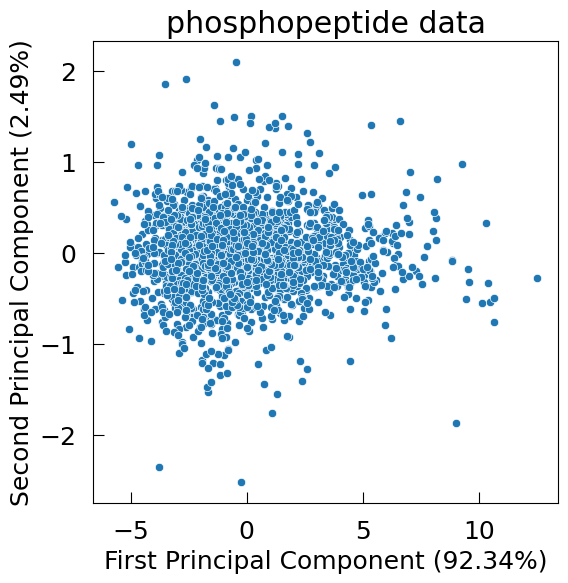

In [37]:
plt.figure(figsize=(6,6))
sns.scatterplot( x = x_pca[:,0] , y = x_pca[:,1]  )
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title("phosphopeptide data")

The **first PC explains 92% of the variance, i.e. the data is almost 1-dimensional!** 

What is going on? Inspection of the data shows that the peptides (rows) have different total intensities and the first PC just reflects this intensity difference.

Text(0, 0.5, 'peptide intensity')

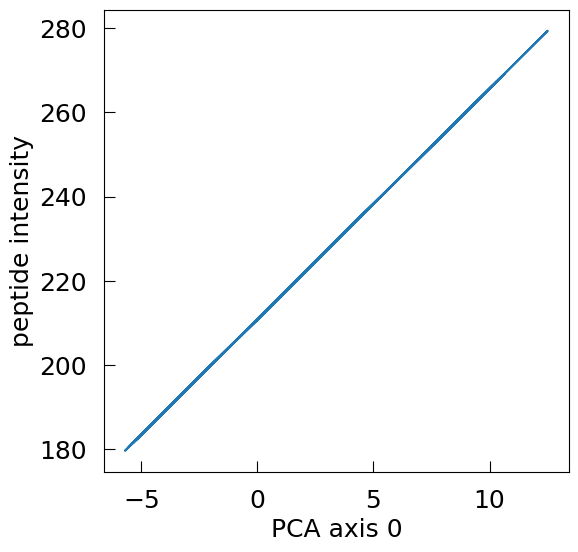

In [38]:
pept_intens = X_ph_positive.sum(axis=1)
plt.plot( x_pca[:,0] , pept_intens)
plt.xlabel( 'PCA axis 0' )
plt.ylabel( 'peptide intensity' )

In this study we are not interested in the total peptide intensity, but only in the relative intensities between treatments (columns). Therefore we can normailze the peptide rows and make sure that each row has a total intensity of 1.

Remark: the PCA class has a 'withen' parameter (see Appendix). However, it does not remove the intensity dependency here and and does not change the plot (try it yourself!).

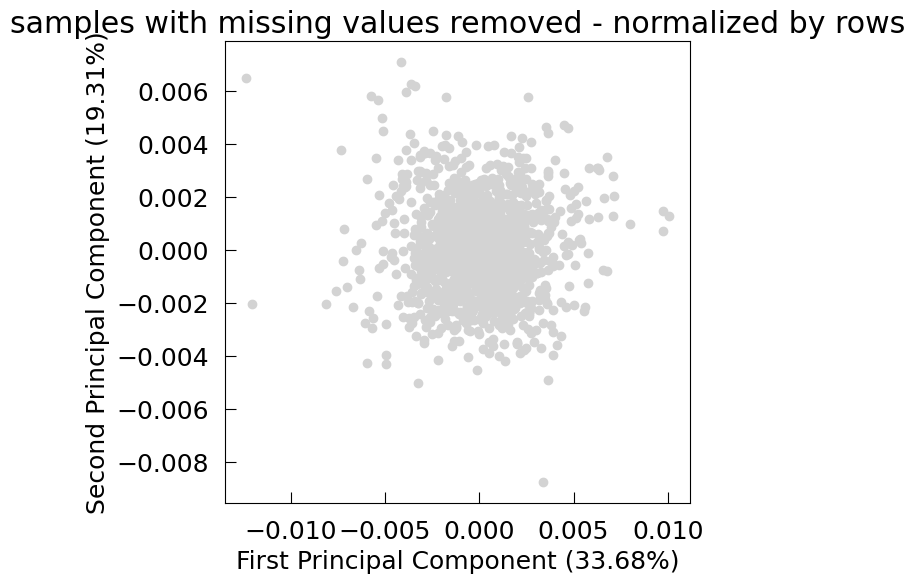

array([3.36765009e-01, 1.93091001e-01, 8.82754674e-02, 7.51505659e-02,
       4.51012785e-02, 3.48305451e-02, 2.63372277e-02, 2.14754890e-02,
       2.05585350e-02, 1.85307757e-02, 1.58547566e-02, 1.28289250e-02,
       1.25353016e-02, 1.13315257e-02, 9.57877334e-03, 9.03889839e-03,
       7.60104741e-03, 7.41077285e-03, 7.18660974e-03, 6.71588726e-03,
       6.04906737e-03, 5.91357953e-03, 4.95354606e-03, 4.64481055e-03,
       4.43507232e-03, 3.95802384e-03, 3.50026905e-03, 3.39868074e-03,
       2.94855771e-03, 1.30495138e-13])

In [40]:
pca = PCA() #create an empty PCA object

X_ph_norm = X_ph_positive.div(pept_intens, axis=0)

pca.fit(X_ph_norm) # calcultes variances (eigenvalues)) and principal components (eigenvectors)
x_pca = pca.transform(X_ph_norm) # calculates coordinates of row vectors in X in PC space


plt.scatter(x_pca[:,0],x_pca[:,1],c='lightgrey')
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title("samples with missing values removed - normalized by rows")
plt.show()

pca.explained_variance_ratio_

We see that the variance along the first PC is now reduced to 34%. Now the PCA plot does not tell us much about the data. We can get more information by plotting the directions that correspond to the individual treatments. We can get the treatment directions via pca.components_, which is our MxM matrix $\pmb{W}^T$ (M = number of columns, features or treatments) where each row holds the PC coordinates in feature space and each column the treatment coordinates in PC space. The rows of pca.components_ are ordered by decreasing variance. 

The visualization of this matrix also reveals that the components of first 5 PC show good aggreement between replicates, and afterwards the PC componenents become noisy.

Text(141.2777777777778, 0.5, 'PC')

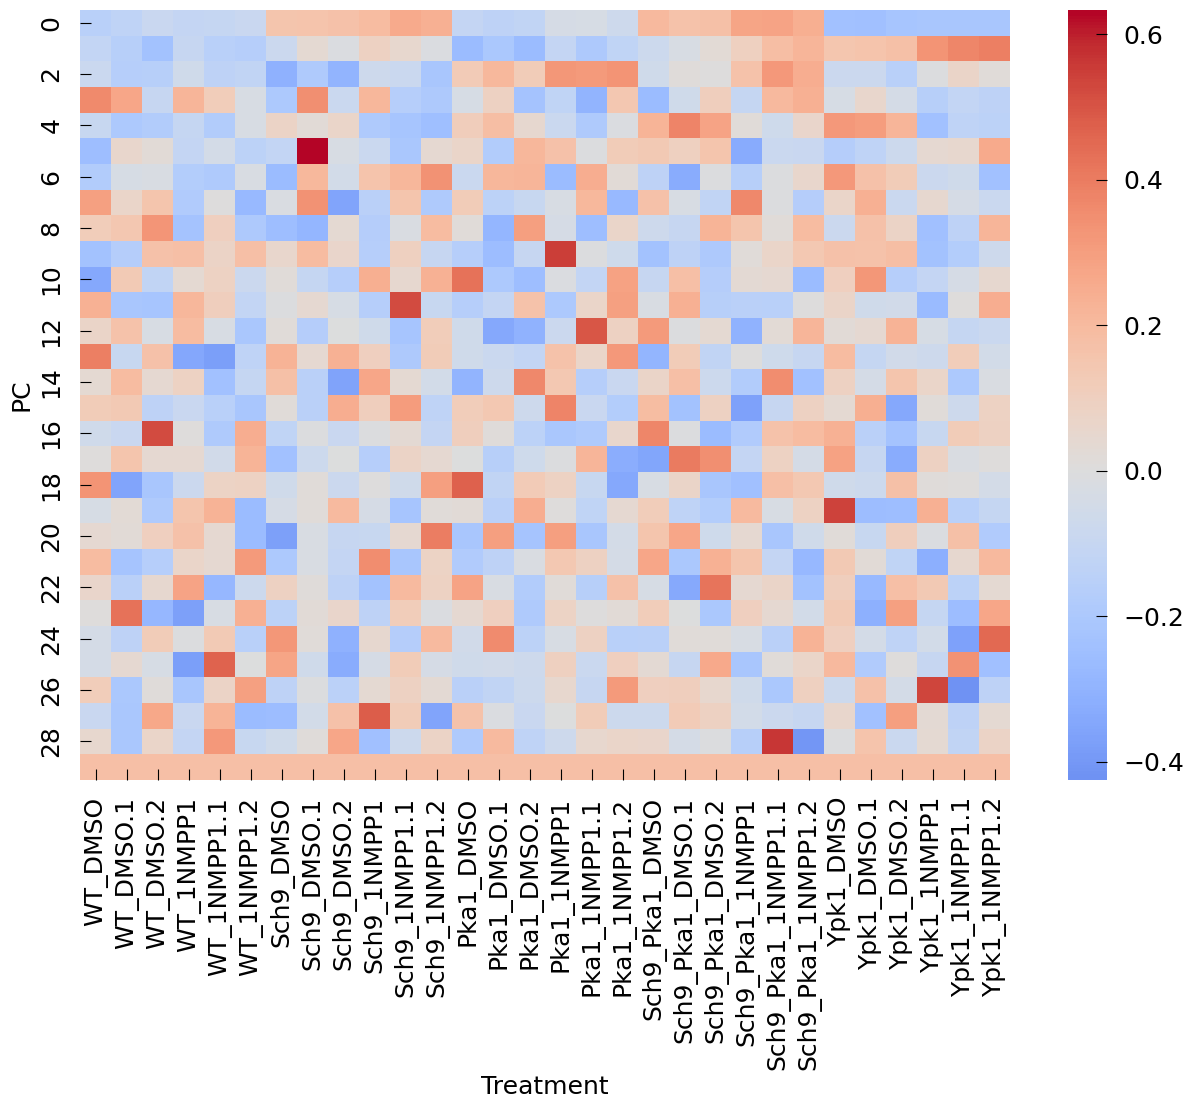

In [46]:
df_comp = pd.DataFrame(pca.components_,columns=X_ph.columns)
fig,ax = plt.subplots(figsize=(15,10))

sns.heatmap(df_comp, cmap='coolwarm', center=0 , ax=ax )
ax.set_xlabel("Treatment")
ax.set_ylabel("PC")

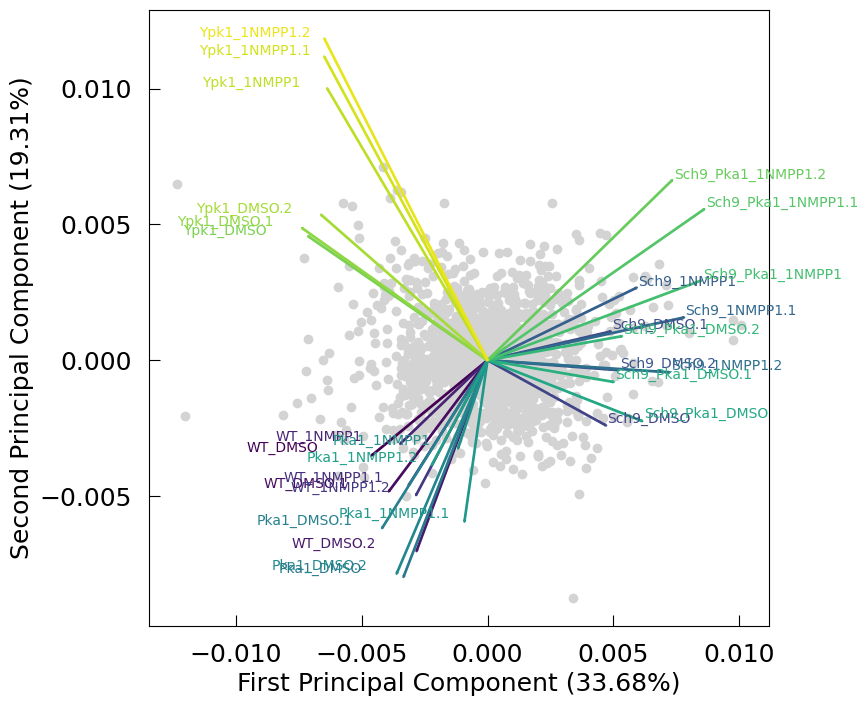

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c='lightgrey')
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

feature_vectors = pca.components_.T
arrow_size = 0.03

# projections of the original features
cmap = colormaps.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.00008, head_length=0.00008, width=0.00005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, X_ph.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)
    

plt.show()


We see now that the Ypk1 mutants cluster together and 1NMPP1 treatments are distinct from DMSO control. Pka1 clusters with the WT strains and there is less difference between treatment and control. Sch9 and Sch9_Pka1 are similar indicating the Sch9 mutant effect is stronger than the Pka1. Overal the mutant effect seems stronger than the treatment effect.

### PCA on the extraverted-introverted dataset <a class="anchor" id="PCAi-bullet"></a>

We have 3 steps here:

 1. imputation (there are a few NAs, a mean imputation is fine for now)
 2. rescaling columns so they are all on the same scale
 3. pca

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. imputation
imputer = SimpleImputer(strategy = 'mean' )
imputer.fit( dfie_OH )
dfI = imputer.transform( dfie_OH )

## 2. scaling
scaler = StandardScaler()
scaler.fit( dfI )
dfS = scaler.transform( dfI )

## 3. PCA
pca = PCA()
pca.fit( dfS )
dfpca = pd.DataFrame( pca.transform( dfS ) , columns=[ f"PC{i}" for i in range(dfS.shape[1]) ] )

pca.explained_variance_ratio_

array([0.80646335, 0.04073081, 0.03588635, 0.03538696, 0.03386465,
       0.02974649, 0.01250138, 0.00542002])

--- 

But before we move forward we can see that setting up these different step one after the other is relatively tedious, and prone to error if we want to apply it to another dataset or change something in the process (eg, how we do the imputation).

For this, sklearn uses [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)


In [49]:
from sklearn.pipeline import Pipeline

## each step in the pipeline is given as a (step name , sklearn object) tuple
ppl_ie = Pipeline( [('impute',SimpleImputer(strategy = 'mean' )),
                    ('scaler', StandardScaler() ),
                    ('pca', PCA() )
                   ])


## fit the whole pipeline and transform the data
xpca = ppl_ie.fit_transform( dfie_OH )

dfpca = pd.DataFrame( xpca , columns=[ f"PC{i}" for i in range(dfS.shape[1]) ] )

ppl_ie['pca'].explained_variance_ratio_

array([0.80646335, 0.04073081, 0.03588635, 0.03538696, 0.03386465,
       0.02974649, 0.01250138, 0.00542002])

Text(0, 0.5, 'PC1 (4.07%)')

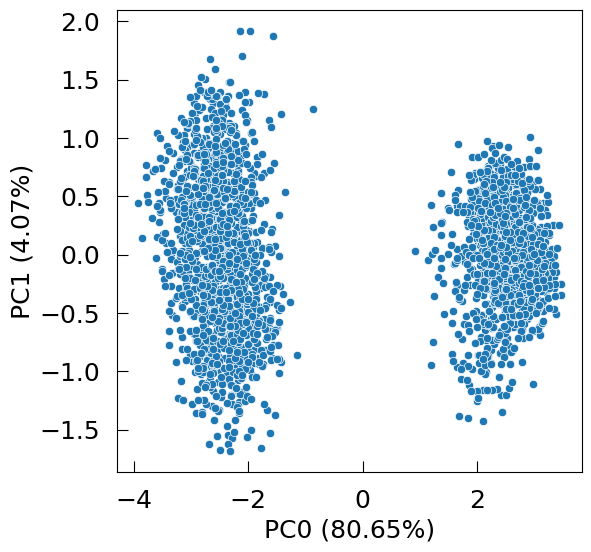

In [50]:
sns.scatterplot(x=dfpca.PC0 , y=dfpca.PC1)
plt.xlabel('PC0 ({0:.2f}%)'.format(ppl_ie['pca'].explained_variance_ratio_[0]*100))
plt.ylabel('PC1 ({0:.2f}%)'.format(ppl_ie['pca'].explained_variance_ratio_[1]*100))

We observe two "clusters". Do they correspond to the self-assigned introvert/extrovert label?

<Axes: xlabel='PC0', ylabel='PC1'>

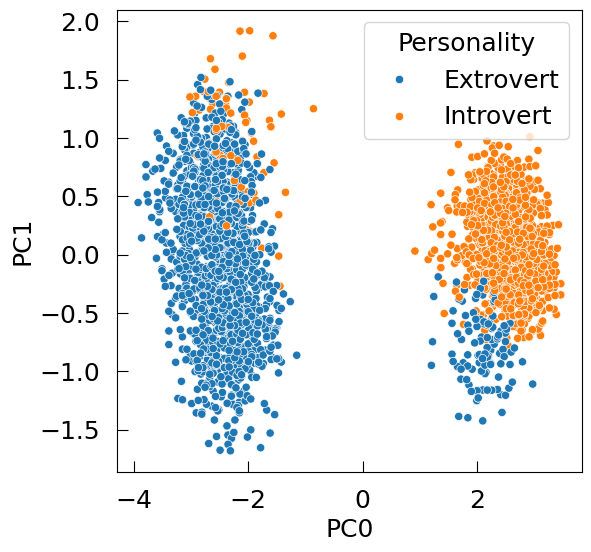

In [57]:
sns.scatterplot( x=dfpca.PC0 , y=dfpca.PC1, hue = dfie.Personality )

It is not unlinked, but it does not correspond exactly

<Axes: >

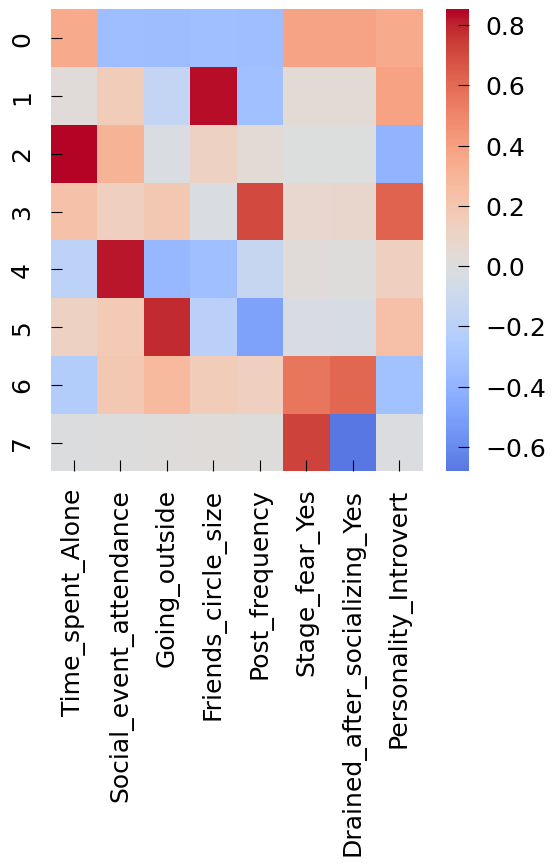

In [52]:
sns.heatmap( ppl_ie['pca'].components_ , 
            cmap='coolwarm', 
            center=0 , xticklabels= dfie_OH.columns)

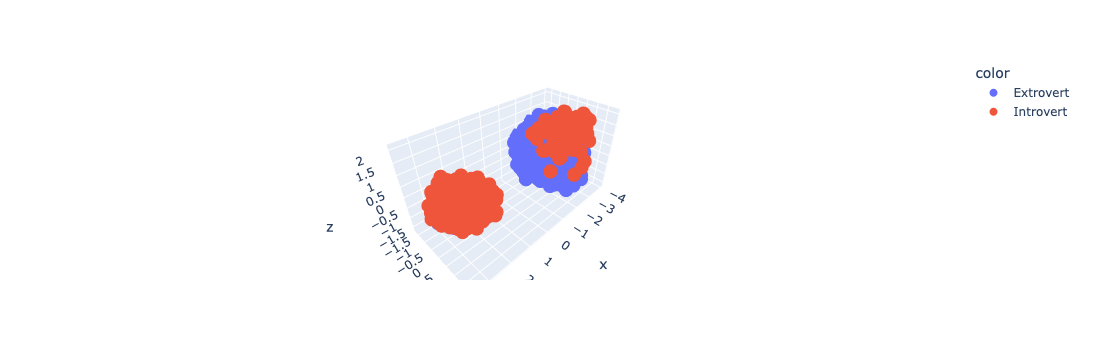

In [59]:
import plotly.express as px

px.scatter_3d(x=dfpca.PC0 , y=dfpca.PC1, z =dfpca.PC3,  color = dfie.Personality)

### t-SNE <a class="anchor" id="tsne-bullet"></a>

t-SNE (t-distributed Stochastic Neighborhood Embedding) is a dimensionality reduction algorithm introduced by [Maaten and Hinton, 2008](https://www.jmlr.org/papers/v9/vandermaaten08a.html). Unlike PCA or ICA it is not a linear method. 

#### A little bit of mathematics:

t-SNE assumes that the in the high dimensional data points are normally distributed with variances $\sigma_i^2$. Namely distance between points $\bf{x_i}$ and $\bf{x_j}$ is represented as: 

$p_{i|j}=\frac{exp(-||x_{i}-x_{j}||^2/(2\sigma_i^2))}{\sum_{k\neq_i}exp(-||x_{i}-x_{k}||^2/(2\sigma_i^2))}$

For the representation in the low dimensional space, t-SNE uses a heavy tailed t-distribution, which does not penalize large distances much. This gives us the flexibility needed to stretch the high dimensional data onto a low dimensional space and will allow better visual separability of the clusters. 

$q_{i|j}=\frac{(1+||y_{i}-y_{j}||^2)^{-1}}{\sum_{k\neq_i}(1+||y_{i}-y_{k}||^2)^{-1}}$

t-SNE forces these two distributions to be as close as possible for a "good" representation. As the similarity measure between the $P_i$ and $Q_i$ distributions they use the Kullback-Leibler divergence:

$C=\sum_{i}KL(P_i||Q_i)=\sum_{i}\sum_{j}p_{i|j}log(\frac{p_{i|j}}{q_{i|j}})$

If the $\sigma_i^2$ values are known t-SNE finds a local minimum in $C({y_i})$ by a gradient descent algorithm. In order to fix the $\sigma_i^2$ values t-SNE uses the 'perplexity' parameter:

$Perp(x_i)=2^{-\sum_{j}p_{j|i}log(p_{j|i})}$


![tSNA illustration](../images/tsne.png)


The higher the `perplexity`, the higher the entropy and the larger $\sigma_i$. `perplexity` therefore reflects the  number of neighbors to consider for the calculation of $p_{i|j}$. A constant perplexity assures that each point will consider approximately the same number of neighbours.

Finally, t-SNE does neither conserve distances nor densities : it is trully a visualization technique and should not be used with other clustering techniques that require distance or density conservation between full and reduced space.

In [60]:
%%time
from sklearn.manifold import TSNE

perplexity = 100

#create the T-SNE object and fit the data
tsne=TSNE(n_components=2,perplexity=perplexity).fit( dfpca )

#project the data to the new manifold using the fitted function found before
X_embedded = tsne.embedding_

CPU times: user 30.9 s, sys: 2.48 s, total: 33.4 s
Wall time: 8.78 s


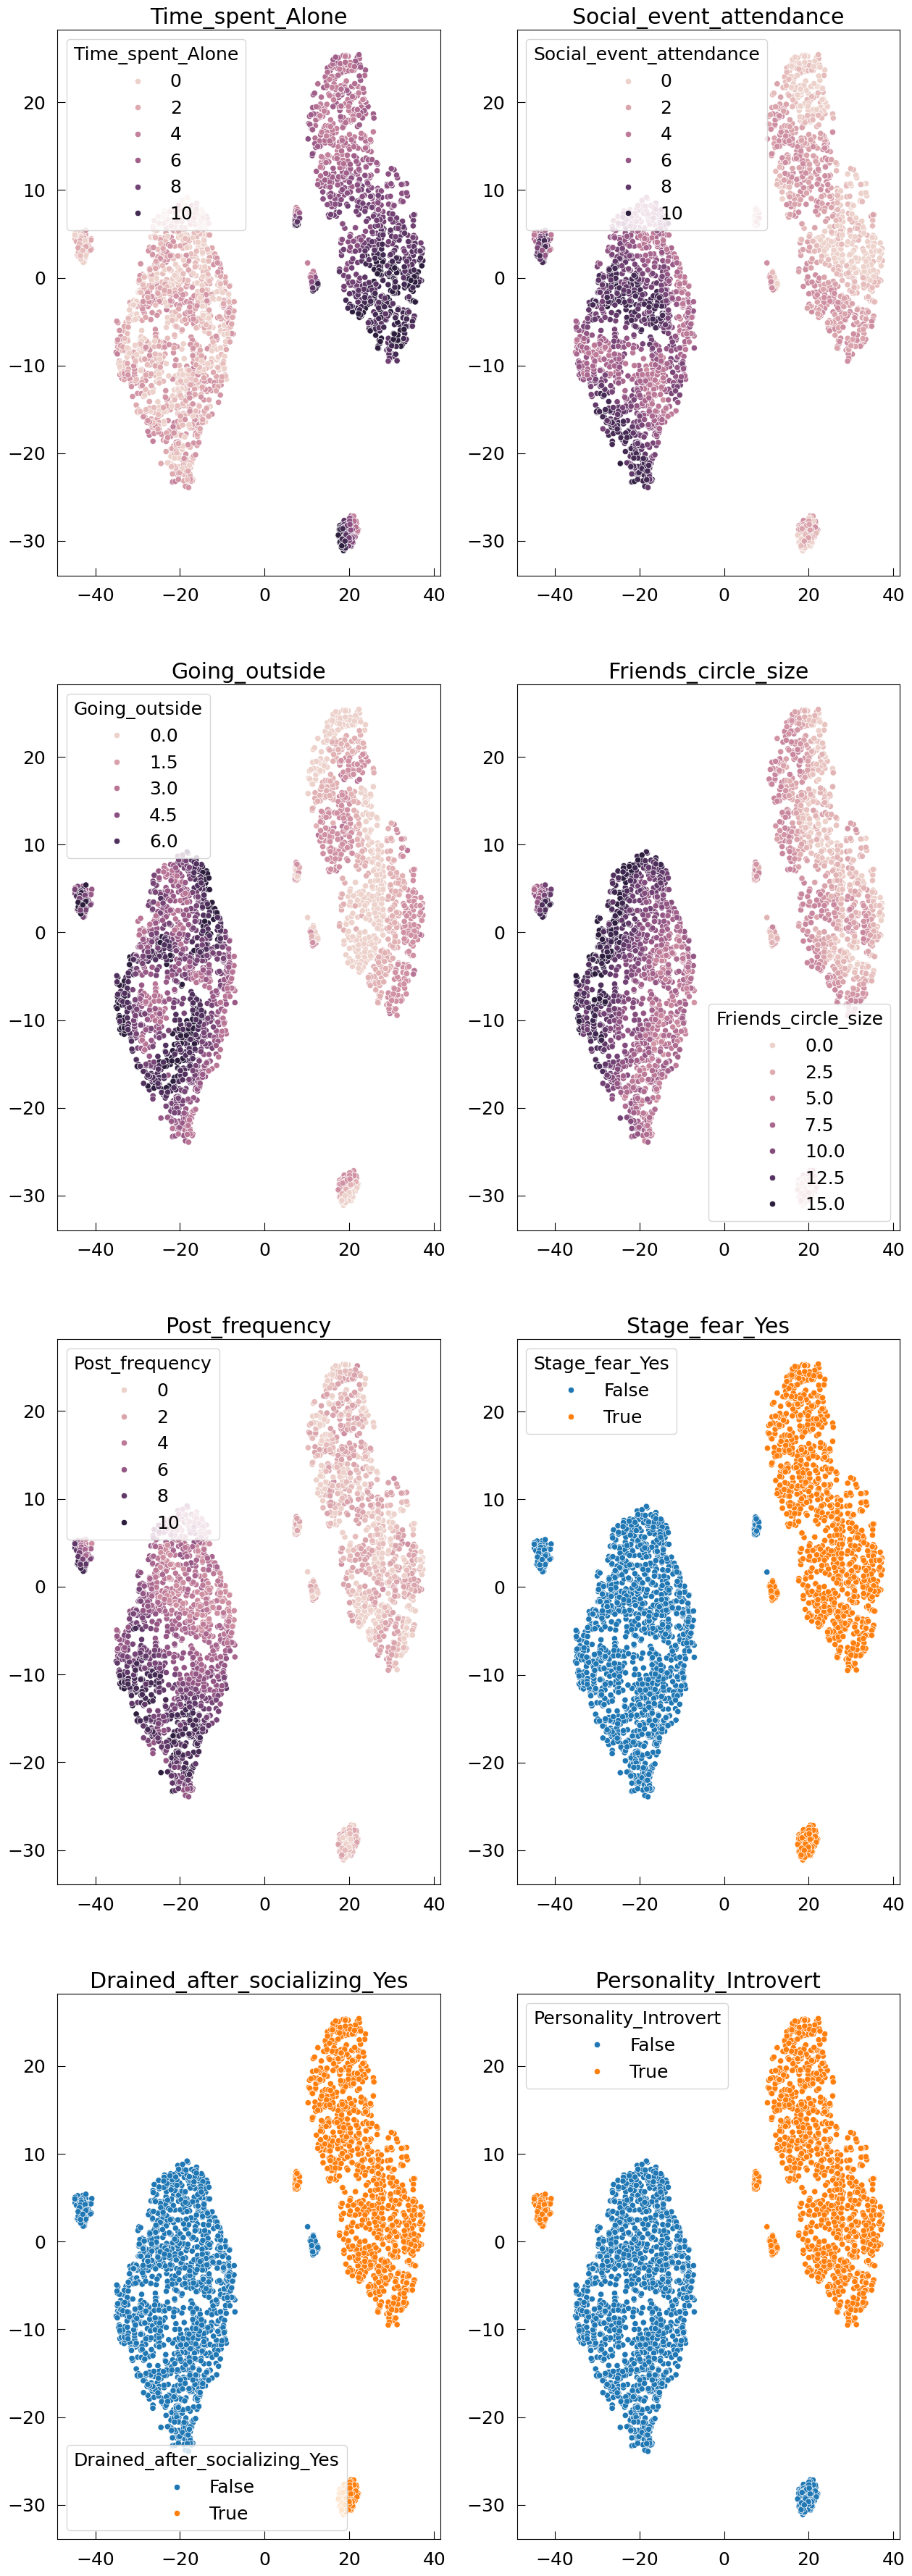

In [61]:
fig,axes = plt.subplots(4,2,figsize=(15,45))

for j,cl in enumerate( dfie_OH.columns ): 
    ax = axes[ j//2 , j%2 ]

    sns.scatterplot(x = X_embedded[:, 0], y = X_embedded[:, 1], 
                    hue = dfie_OH[cl] , 
                    ax=ax )
    ax.set_title(cl)


Making a direct correspondance between the new and the former basis is not straight forward, since the transformation is non-linear and dependent on the position in the reduced space. Yet to get a feeling about what the features represent you can color code the feature values and see how they change in the transformed space.


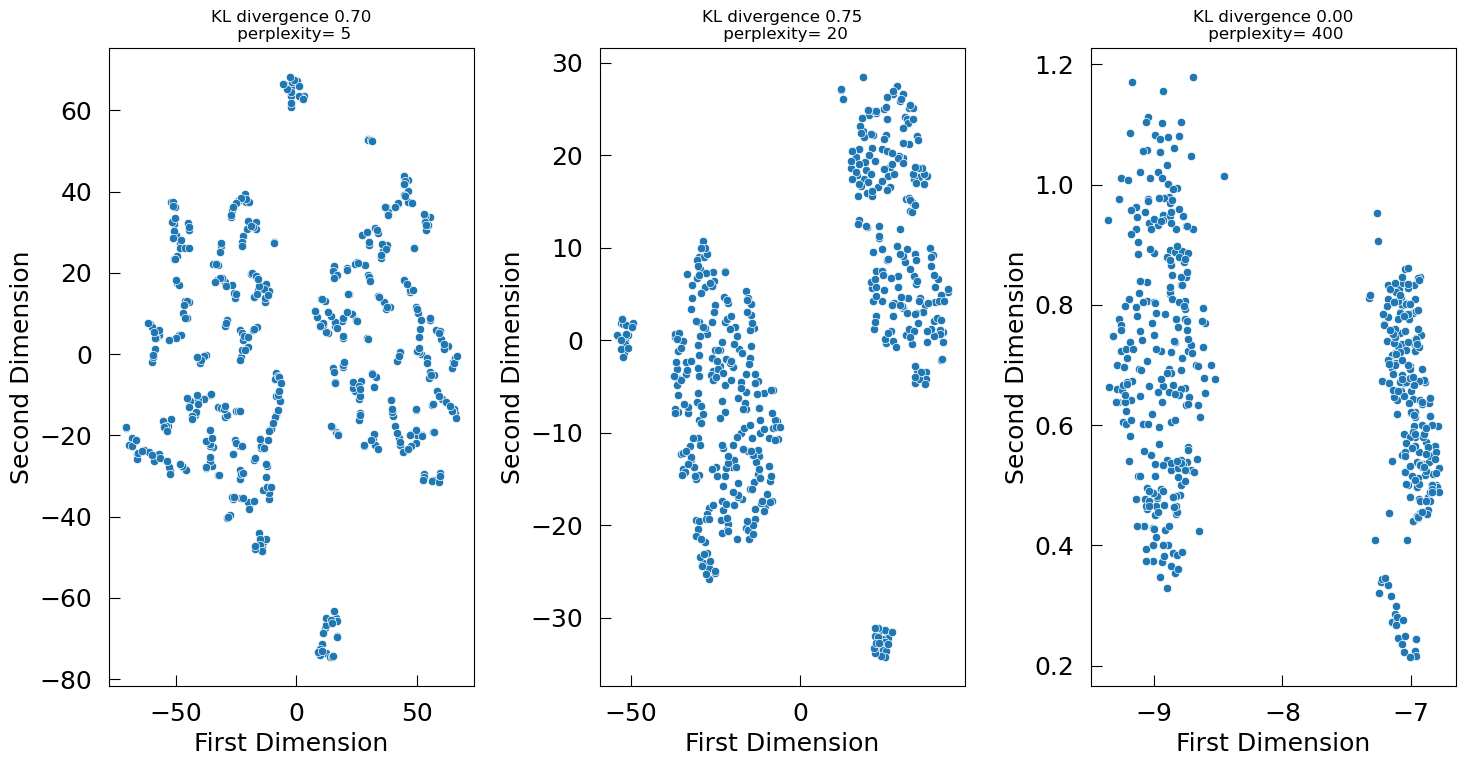

In [62]:
## TSNE gets very slow when the data is large
##    for this demonstration we subsample the data for 
subset = dfpca.sample(n=500)

p=[5,20,400] #perplexity parameters to test
fig,ax = plt.subplots(1,len(p) , figsize=(15,8))

for i,perplexity in enumerate( p ):
    
    tsne = TSNE(n_components = 2,perplexity = perplexity)
    tsne.fit( subset )
    
    sns.scatterplot(x = tsne.embedding_[:, 0], y = tsne.embedding_[:, 1] , ax = ax[i])

    ax[i].set_xlabel('First Dimension')
    ax[i].set_ylabel('Second Dimension')
    ax[i].set_title(f'KL divergence {tsne.kl_divergence_:.2f}\n perplexity= {perplexity}',fontsize=12)
plt.tight_layout()
plt.show()

You can also see that the perplexity parameter determines the topology of the results. It is your guess to pick a perplexity parameter that gives the best representation of your data. For more details I highly encourage everybody to take a look at this [article](https://distill.pub/2016/misread-tsne/)

[Back to ToC](#toc)

## Exercise: PCA <a id="exo-pca"></a>

**Another dataset : AML**

In the following dataset from [Tyner et al. 2018](https://doi.org/10.1038/s41586-018-0623-z) we have the expression level of some genes from some different Acute Myeloid Leukaemia (AML) tumors as well as how they respond to treatment (AUC value). 

Between those different tumors there are probably different mutations occuring in different genes.

In [63]:
df_aml=pd.read_excel('../data/gene_drug_sens.xlsx')
df_aml.head()

sample Disease_type                  ELN2017 Cytogenetics    Mclust  \
0  12-00023       Denovo             Intermediate          NaN  Cluster1   
1  12-00051       Denovo  FavorableOrIntermediate          NaN  Cluster2   
2  13-00118      Relapse                Favorable          NaN  Cluster1   
3  13-00149        Other             Intermediate          NaN  Cluster1   
4  13-00160  Transformed             Intermediate          NaN  Cluster1   

          auc  FLT3_ITD      NPM1    DNMT3A      CD86  ...     ADAP2  \
0  257.569985  negative  negative       NaN -1.120073  ... -1.001751   
1  168.267467  positive  positive       NaN  2.498957  ... -0.933841   
2  271.034652  negative  positive  positive  0.176687  ... -0.185127   
3  286.109498  negative  negative  negative  0.918236  ... -0.333728   
4  261.794860  negative  negative  negative -1.004299  ...  0.564804   

     B3GNT2  RP11-196G18.24      TLR2    MIR223   RAB43P1      GYPC  HSD17B13  \
0  1.556003       -1.608982  0.751515  0.987769  0.232332  0.981147 -2.021119   
1 -0.189892        0.313041  2.097701 -1.627445 -0.961402 -0.523684  0.255906   
2  0.235198       -1.389968  0.007096  1.291810 -0.504791  0.813038 -0.741312   
3  0.038227       -0.187054 -0.376509  0.826023  0.847269 -0.466044  0.374157   
4 -0.835560       -0.566891  0.546441 -0.371254  1.609191  0.220240 -2.180800   

    HNRNPA1     NAPSB  
0 -1.185687 -0.710025  
1  0.885343  0.900553  
2 -1.180863 -2.541507  
3  0.585562 -0.747859  
4  1.076900  0.411095  

[5 rows x 26 columns]

In [64]:
## let's keep only the expression data as well as the response to treatments (auc)
X_aml=df_aml[df_aml.columns[9:]]
X_aml.head()

CD86    FAM49A      ERMN      CHD5  RP11-333E13.2    KLHDC3      HNMT  \
0 -1.120073 -0.148654 -1.579624 -0.756073       0.471452  1.068268 -0.157964   
1  2.498957 -1.015880 -0.859471 -0.555560      -0.142550 -0.161521  2.279642   
2  0.176687 -0.490400 -0.611194 -0.443875       0.876031 -0.147330  0.112438   
3  0.918236  0.377131 -0.410336 -0.033461      -0.014791  1.218267  1.122505   
4 -1.004299 -0.826399  0.995739 -1.426430      -0.053345  0.585897 -0.876732   

      ADAP2    B3GNT2  RP11-196G18.24      TLR2    MIR223   RAB43P1      GYPC  \
0 -1.001751  1.556003       -1.608982  0.751515  0.987769  0.232332  0.981147   
1 -0.933841 -0.189892        0.313041  2.097701 -1.627445 -0.961402 -0.523684   
2 -0.185127  0.235198       -1.389968  0.007096  1.291810 -0.504791  0.813038   
3 -0.333728  0.038227       -0.187054 -0.376509  0.826023  0.847269 -0.466044   
4  0.564804 -0.835560       -0.566891  0.546441 -0.371254  1.609191  0.220240   

   HSD17B13   HNRNPA1     NAPSB  
0 -2.021119 -1.185687 -0.710025  
1  0.255906  0.885343  0.900553  
2 -0.741312 -1.180863 -2.541507  
3  0.374157  0.585562 -0.747859  
4 -2.180800  1.076900  0.411095

In [65]:
# you access the AUC using 
df_aml.auc

0     257.569985
1     168.267467
2     271.034652
3     286.109498
4     261.794860
         ...    
85    135.218527
86    278.970613
87    124.302935
88    174.745142
89    259.485443
Name: auc, Length: 90, dtype: float64

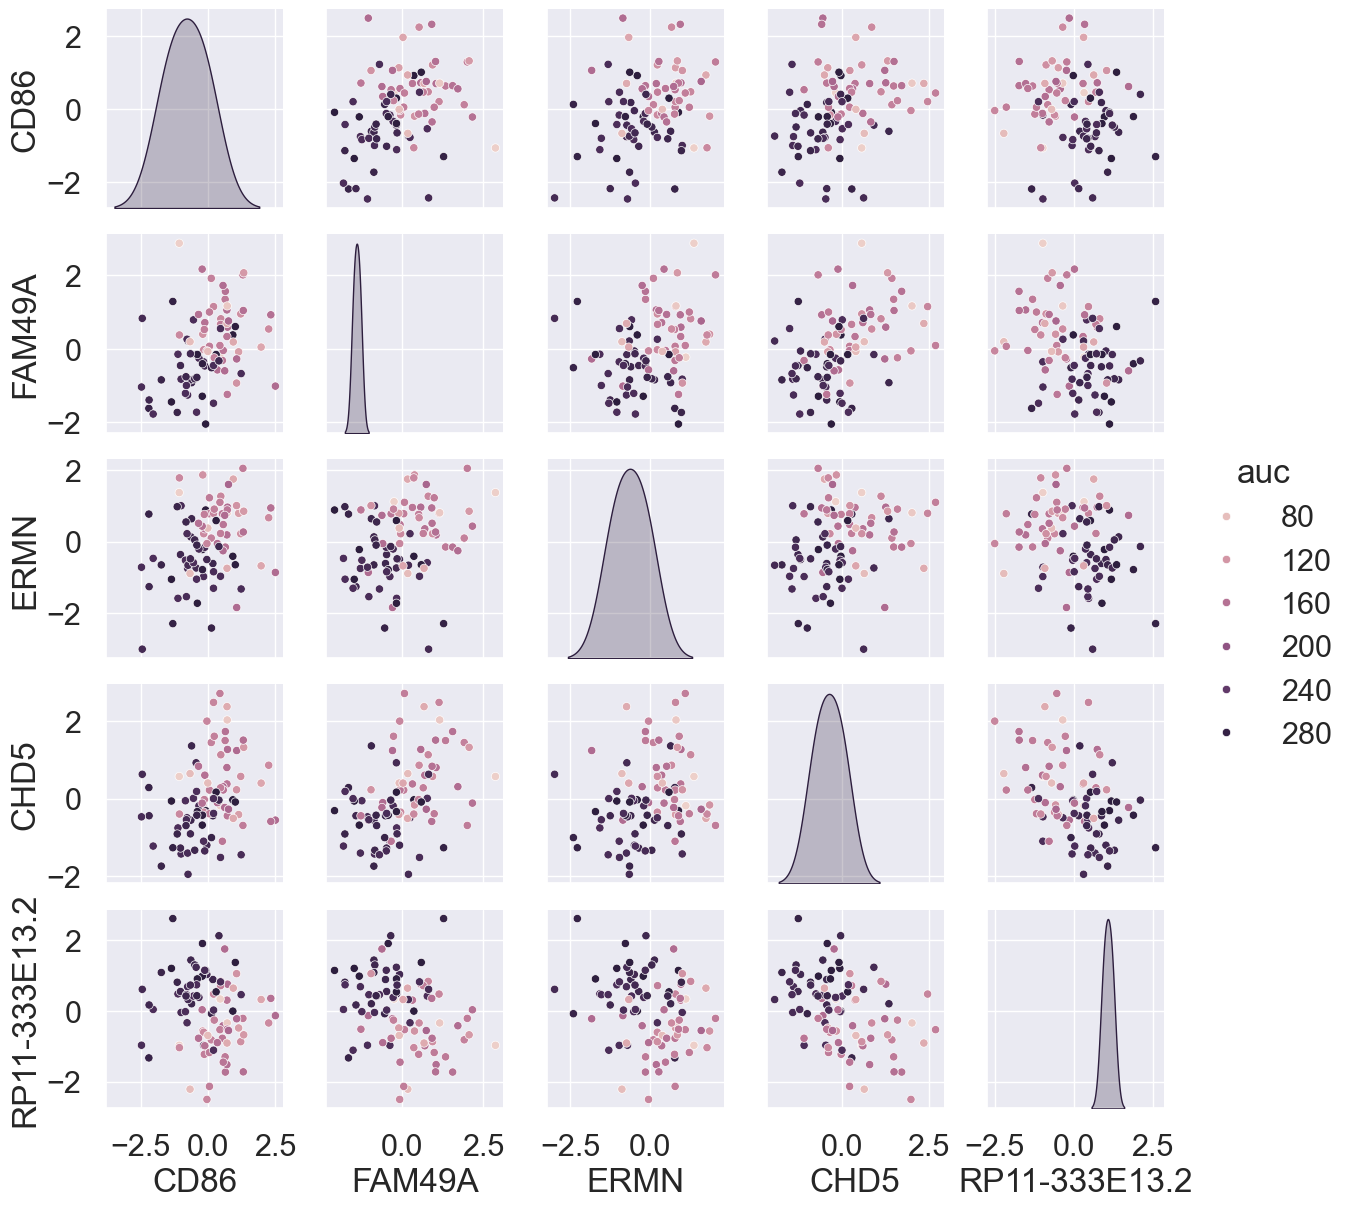

In [66]:
## WARNING : doing this with all columns takes a couple of minutes
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set(font_scale = 2)
sns.pairplot(df_aml.loc[:, ['auc'] + list(X_aml.columns)[:5]],
             hue="auc")

You can presume that the missing values and data normalization for the gene expression have already been handled.

Perfom a pca on the gene expressions. Choose an interesting number of dimension and interpret the plot : 

 * What does the first component stand for? 
 * What are driving genes behind the first components? 
 
 
**If you have the time:** use other dimensionality reduction techniques such as t-SNE. What do you think?

In [112]:
from sklearn.decomposition import PCA
pca = PCA() #create an empty PCA object

pca.fit(X_aml) # calculates variances (eigenvalues)) and principal components (eigenvectors)

x_pca = pca.transform(X_aml) # calculates coordinates of row vectors in X in PC space

x2pca = pd.DataFrame( pca.transform( X_aml ) , columns=[ f"PC{i}" for i in range(X_aml.shape[1]) ] )


pca.explained_variance_ratio_

## pca.explained_variance_ratio_ contains the fraction of the variance explained by each PCA axis (don't forget the _ at the end) 
pca.explained_variance_ratio_


array([0.34975331, 0.08327885, 0.07270033, 0.0635164 , 0.05709616,
       0.05383238, 0.0447606 , 0.04396284, 0.0408951 , 0.03799109,
       0.03223835, 0.02803123, 0.02608361, 0.02083041, 0.0169615 ,
       0.01534611, 0.01272174])

Text(0.5, 1.0, 'gene expressions data')

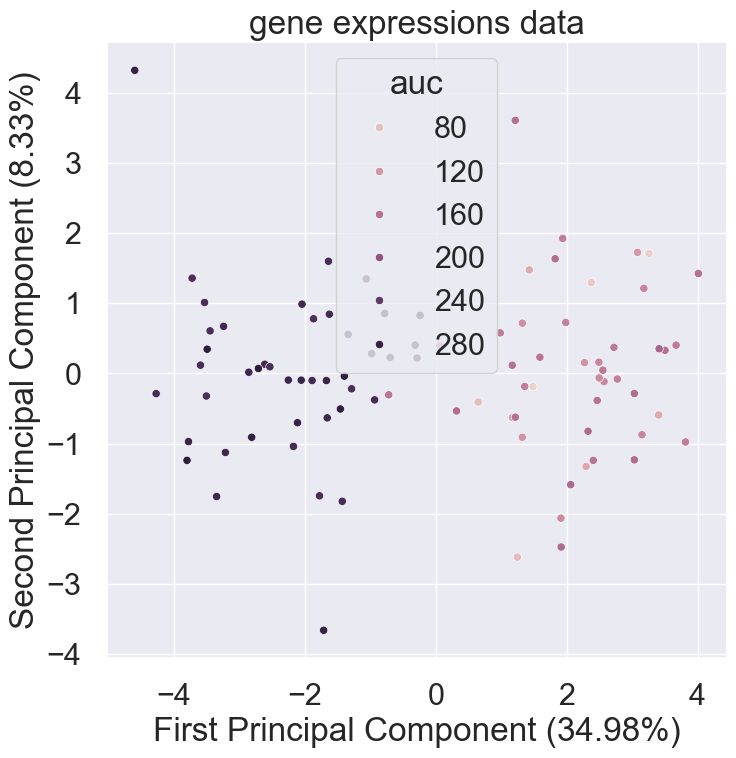

In [102]:
plt.figure(figsize=(8,8))
sns.scatterplot (x= x_pca[:,0] , y = x_pca[:,1] , hue = df_aml.auc)
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title("gene expressions data")

<Axes: >

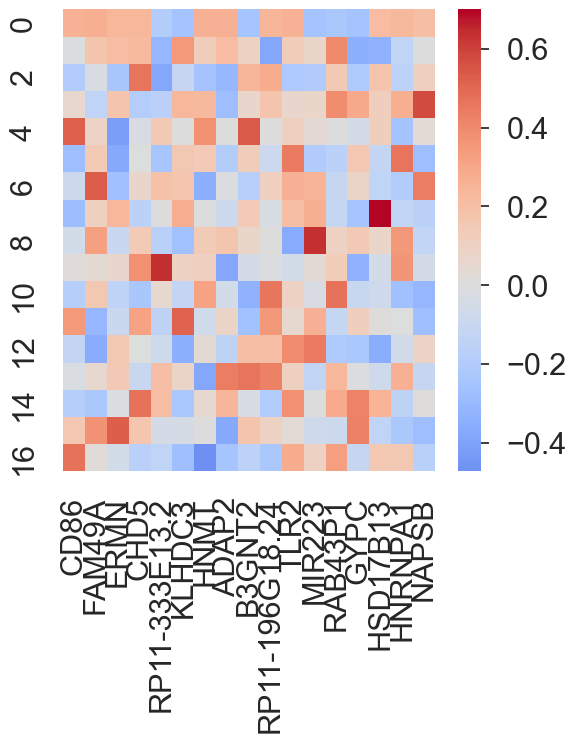

In [83]:
sns.heatmap(pca.components_ , 
            cmap='coolwarm', 
            center=0 , xticklabels= X_aml.columns)

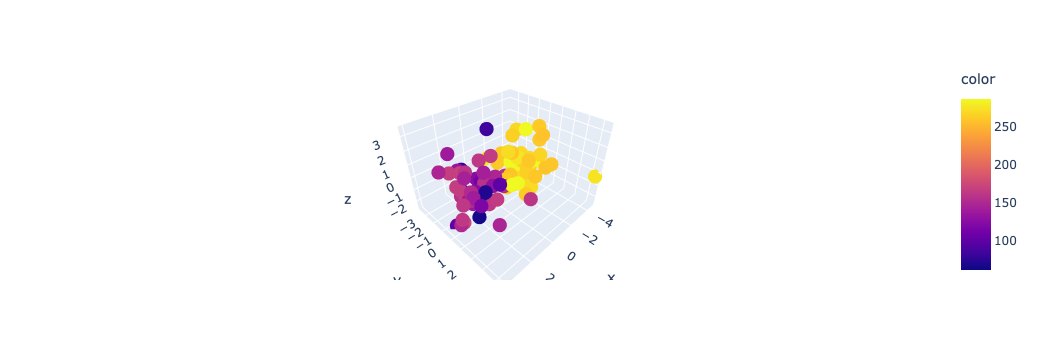

In [114]:

px.scatter_3d(x=x2pca.PC0 , y=x2pca.PC1, z =x2pca.PC2, color = df_aml.auc )

You can look up the solution by uncommenting andexecution the following line:

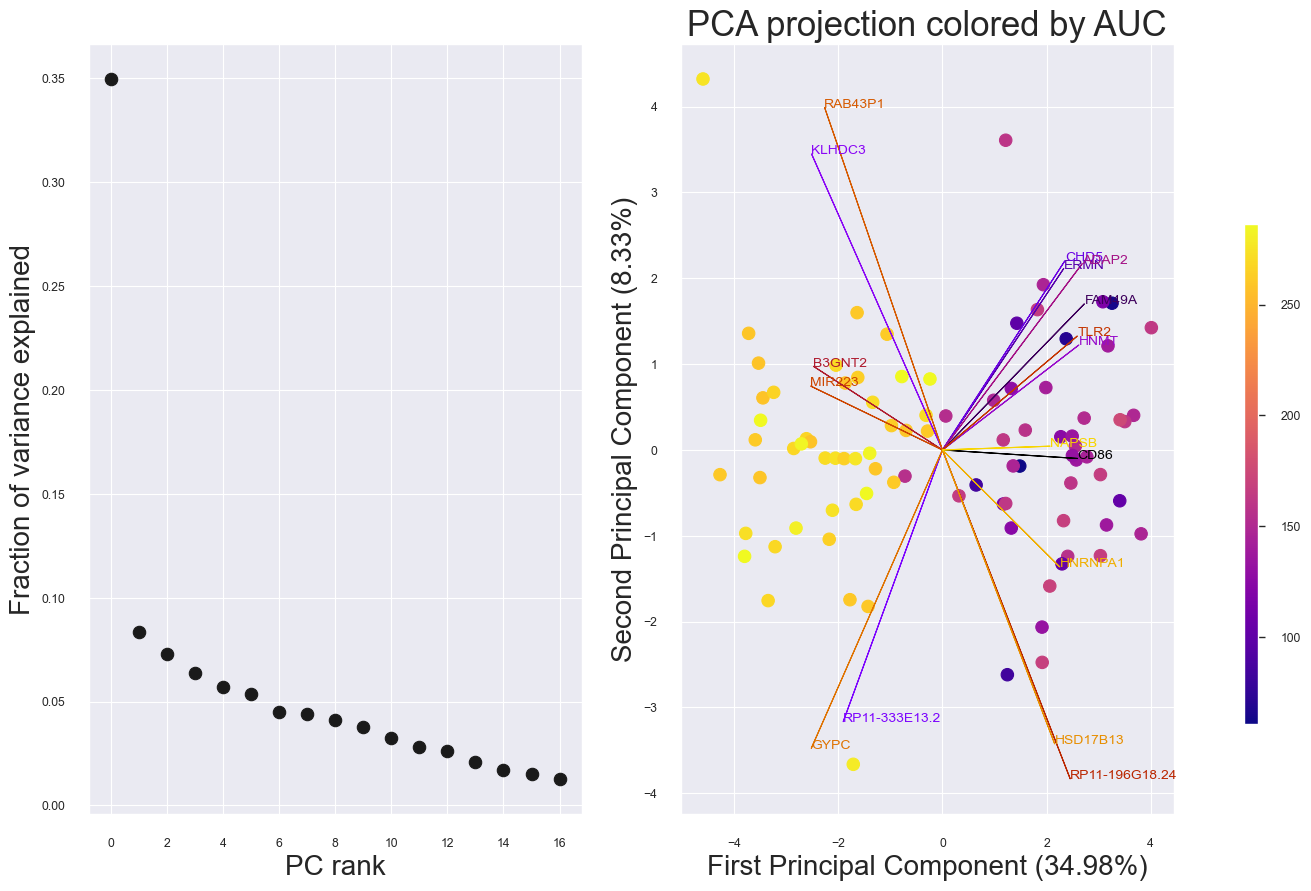

In [110]:
# %load solutions/solution_01_pca.py
import seaborn as sns

sns.set_context("paper", rc={"axes.labelsize":20})
pca = PCA()

## we fit and transform the PCA on the gene expression data only (all columns except the last one).
x_pca = pca.fit_transform(X_aml) # calculates coordinates of row vectors in X in PC space

## we extract the components weights
feature_vectors = pca.components_.T

## plotting 
arrow_size = 10

fig,axes = plt.subplots(1,2,figsize=(14,10))

# left subplot : %explained variance for each axis
axes[0].scatter(np.arange(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_,s=80,c='k')
axes[0].set_ylabel('Fraction of variance explained')
axes[0].set_xlabel('PC rank')


# right subplot : PC0 and PC1, colored by auc

aa=axes[1].scatter(x_pca[:,0],x_pca[:,1],c=df_aml.auc,s=80,cmap='plasma')
axes[1].set_xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
axes[1].set_ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

cmap = plt.get_cmap('gnuplot')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    axes[1].arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.00008, head_length=0.00008, width=0.00005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    axes[1].text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, X_aml.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)


axo = fig.add_axes([0.95,0.2,0.01,0.5])

axes[1].set_title("PCA projection colored by AUC",fontsize=25)
fig.colorbar(aa, ax =axes[1] , cax=axo, orientation='vertical' , fraction=0.01)

# Appendix <a class="anchor" id="appendix-bullet"></a>

## 'Whiten' a data matrix <a class="anchor" id="whiten-bullet"></a>

'Whitening' is a process to reduce correlations between columns in a $NxM$ data matrix $\pmb{X}$ ($N$ samples and $M$ features). It uses PCA to transform $\pmb{X}$ into $\pmb{X'}$ with $\pmb{X'}^T\pmb{X'}=\pmb{\mathbb{1}}$. The process consists of 2 steps:

<ol>
<li>Zero centering around column means: $x_{ij}=x_{ij}-\frac{1}{N}\sum_{k=1}^{N}x_{kj}$</li>
<li>Rotation to PC basis and scaling: $\pmb{X'}=\pmb{X}\pmb{W}\pmb{D^{-\frac{1}{2}}}$, where $\pmb{W}$ is the matrix containing the PC's and D a diagonal matrix containing the variances. This transformation projects on the PC basis vectors and divides by the standard deviations.</li>
</ol>



## UMAP <a class="anchor" id="umap-bullet"></a>

t-SNE has some disadvantages:

<ol>
<li>Speed. t-SNE computations takes a long time for large datasets</li>
<li>Dimensions. t-SNE is not applicable for more than 2-3 dimensions</li>
<li>Global Structure: t-SNE preserves local but not global structure</li>
</ol>

There comes UMAP ([McInnes et al.,arxiv, 2018](https://arxiv.org/abs/1802.03426)), which you probably know from single cell RNA-seq papers. It is similar to t-SNE, but differs in some important details, which make it faster, applicable to more than 2 dimensions and preserve the global structure better. Here is how it works:

UMAP assumes a exponential weight between the high dimensional data points: 

$\mu_{ij}=e^{-\frac{d(x_{i},x_{j})-\rho_i}{\sigma_i}}$

$\rho_i$ is the distance $d(x_{i},x_{k})$ of $x_{i}$ to its nearest neighbor $x_{k}$. Let $NN(i,n)$ be the set of $n$ nearest neighbors of $x_i$. $sigma_i$ is chosen such that $\sum_{k \in NN(i,n)}\mu_{ik} = log_2(n)$. In contrast to t-SNE the weights are not normalized, which saves computation time.

Next the weights $mu_{ij}$ are turned into a weighted adjacency matrix and spectral clustering is used to find an initial embedding of the data points in the low dimensional space.

For the representation in the low dimensional space, UMAP uses a heavy tailed weight:

$\nu_{ij} = (1 + a(|x_i − x_j|_2^2)^b)^{−1}$

UMAP determines the parameters $a$ and $b$ by a least square fitting procedure. As a similarity measure between the $\mu_{ij}$ and $\nu_{ij}$ distributions it uses:

$C=-\sum_{i}\sum_{j}[\mu_{ij}log(\nu_{ij}) + (1-\mu_{ij})log(1-\nu_{ij})]$

UMAP uses stochastic gradient descent algorithm to minimize $C$. The spectrum clustering initialisation as well as the second term in $C$ are supposed to provide a better embedding for distant clusters compared to t-SNE.

UMAP implements an efficient nearest neighbor search and has an overall complexity of $O(N^{1.14})$.

The main input parameters for UMAP are

<ol>
<li>'n_components': dimension of the embedding</li>
<li>'n_neighbors': numer of nearest neigbors to consider (corresponds to $n$ in the text)</li>
<li>'min_dist': points in embedded space need to be separeted by a distance of at least 'min_dist'</li>
<li>'metric': metric to be used for measuring distances (corresponds to $d(x,y)$ in the text)</li>
</ol>

Further information and tutorials you can find un the [UMAP page](https://umap-learn.readthedocs.io/en/latest/index.html).

In [ ]:
## you'll likely have to install the umap library:
#!conda install -y -c conda-forge umap-learn

In [ ]:
%%time
from umap import UMAP

## TSNE gets very slow when the data is large
##    for this demonstration we subsample the data for 
subset = dfpca.sample(n=500)

n_neighbors =[2,5,20] 
fig,ax = plt.subplots(1,len(n_neighbors) , figsize=(8*len(n_neighbors),8))

for i,nn in enumerate( n_neighbors ):
    
    umaper = UMAP(n_components = 2,n_neighbors=nn)
    embedding = umaper.fit_transform( subset )
    
    sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1] , ax = ax[i])
    ax[i].set_xlabel('First Dimension')
    ax[i].set_ylabel('Second Dimension')
plt.tight_layout()
plt.show()

### Independent Component Analysis <a class="anchor" id="ICA-bullet"></a>

Independent Component Analysis (ICA) comes from the field of signal processing, where it was developped to deconvolve an additive mixture of signals into the source components. Mixtures tend to be gaussian and individual sources non-gaussian and PCA will fail ro recover the sources. In ICA we will not look for directions with the largest variance as in PCA, but for directions with the most non-gaussian distributions. This can also be an informative approach for biological data, where the non-gaussian signal often correspond to informative feature combinations. Also the directions found by ICA do not need to be orthogonal allowing more fexibility in the source decomposition.

In ICA we look for independent components (IC) of a $N$x$M$ data matrix $\pmb{X}$, where the ICs are represented as rows of a $M$x$M$ matrix $\pmb{W}$. ICA looks for an IC basis $\pmb{W}$ such that the columns $\pmb{S}_j$ of the $N$x$M$ source matrix $\pmb{S}=\pmb{X}\pmb{W}^T$ are as non-Gaussian as possible i.e. they maximize a function $F(\pmb{S}_i)$ that is the larger the more $S_{ij}, i=1..N$ deviate from a Gaussian distribution. Before finding the independent components, the data matrix $\pmb{X}$ is usually 'whitened' (see Appendix). 

sklearn provides the [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA.transform) algorithm for ICA decomposition (see [Hyvärinen & Oja, Neural Networks, 2000](https://www.sciencedirect.com/science/article/abs/pii/S0893608000000265?via%3Dihub)). It provides fit($\pmb{X}$) and transform($\pmb{X}$) methods. fit() calculates the IC matrix $\pmb{W}$ (stored in FastICA.components_), the whithening mean $m=\frac{1}{N}\sum_{k=1}^{N}x_{kj}$ (stored in FastICA.means_), as well as the the mixing matrix $\pmb{A}$ (stored in FastICA.mixing_), $\pmb{X}=\pmb{S}\pmb{A}^T+m$, which is the (pseudo) inverse of $\pmb{W}$.

In [ ]:
from sklearn.decomposition import FastICA


ica = FastICA(whiten='arbitrary-variance', random_state=1,n_components=9)

ica.fit(X_ph_positive)
x_ica = ica.transform(X_ph_positive)

plt.subplots(figsize=(16,8))


plt.scatter(x_ica[:,0],x_ica[:,1])
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')

feature_vectors = ica.components_.T

arrow_size = 0.5

# projections of the original features
cmap = plt.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    v = v/np.linalg.norm(v)
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.0008, head_length=0.0008, width=0.0005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, X_ph_positive.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)


## PCA for breast cancer data <a class="anchor" id="bc-bullet"></a>

The breast cancer dataset is a classic dataset that was used in an early ML application ([Wolberg et al, Cencer Letters, 1994](https://www.sciencedirect.com/science/article/abs/pii/030438359490099X?via%3Dihub)). In this paper 
fine-needle aspirates from breast tissues were digitally scanned. The cell images were processed by a automated software and 10 features describing size and shape of the cell nuclei were extracted. For each feature the mean, the maximum and the standard deviation were measured resulting in 30 features.

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

scaler = StandardScaler()
X_cancer = scaler.fit_transform(X_cancer)


df_cancer = pd.concat([pd.DataFrame(X_cancer,columns=cancer['feature_names']),\
                       pd.DataFrame(y_cancer,columns=['malignant'])],axis=1)

pca = PCA() #create an empty PCA object

from sklearn.preprocessing import StandardScaler

x_pca = pca.fit_transform(X_cancer) # calculates coordinates of row vectors in X in PC space

plt.figure(figsize=(10,10))
sns.scatterplot( x = x_pca[:,0], y = x_pca[:,1],hue = y_cancer )
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

feature_vectors = pca.components_.T
arrow_size = 25

# projections of the original features
cmap = plt.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.00008, head_length=0.00008, width=0.00005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, df_cancer.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)
    
    
plt.show()

## PCA for Iris data <a class="anchor" id="iris-bullet"></a>

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                     pd.DataFrame(iris['target'],columns=['species'])],axis=1)

df_iris.head()


The Iris data is another dataset used many times in ML examples. In contains 150 cases of iris flowers devided into 3 species (setosa, versicolor, virginica) of 50 cases each. There are four features: sepal_length, sepal_width, petal_length, petal_width measured in cm.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                       pd.DataFrame(iris['target'],columns=['species'])],axis=1)

(X_iris, y_iris) = load_iris(return_X_y = True)

scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)

pca = PCA() #create an empty PCA object

from sklearn.preprocessing import StandardScaler

x_pca = pca.fit_transform(X_iris) # calculates coordinates of row vectors in X in PC space

plt.figure(figsize=(10,10))
sns.scatterplot( x = x_pca[:,0], y = x_pca[:,1],hue = iris['target_names'][y_iris] )
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

feature_vectors = pca.components_.T
arrow_size = 2

# projections of the original features
cmap = plt.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.00008, head_length=0.00008, width=0.00005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, df_iris.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)
        
plt.show()

## Looking at the code <a class="anchor" id="code-bullet"></a>

If you would like to know what the function PCA.transform(), PCA.fit() or any other python function are doing exactly, it is a good idea to inspect the source code of these functions:

In [ ]:
from sklearn.decomposition import PCA
import inspect

print(inspect.getsource(PCA.transform))